 **Project: Using NLP for Requirements Engineering for Data Management Software**
 
Source data: Stackoverflow question and answers concerning Azure Data Factory 
    
    Tags: azure-data-factory, adf 
    
    Title keywords: azure data factory, adf
    
Link to data source: https://data.stackexchange.com/stackoverflow/query/new

Link to generated schema: https://dbdiagram.io/d/6448f5b26b3194705139098b

Link to GitHub Repo: https://github.com/tanwolf/NLP_Requirements-Engineering

**Purposes of this notebook:** 
- Explore raw data about Azure Data Factory and pre-process it for NLP exploration
- Explore keywords as potential filters for relevant sub-sets
- explore possible sub-sets

**SQL Query**

SELECT

    q.Id AS QuestionId,
    
    q.Title AS QuestionTitle,
    
    q.Body AS QuestionBody,
    
    q.Tags AS QuestionTags,
    
    q.CreationDate AS Date,
    
    q.ViewCount AS ViewCount,
    
    q.Score AS Score,
    
    q.AnswerCount AS NumberOfAnswers,
    
    a.Id AS AnswerId,
    
    a.Body AS AnswerBody

FROM 

    Posts q

INNER JOIN 

    Posts a ON a.ParentId = q.Id

WHERE

    q.PostTypeId = 1
    
    AND (
    
        q.Tags LIKE '%<azure-data-factory>%'
        
        OR q.Tags LIKE '%<adf>%'
        
        OR q.Title Like '%<azure data factory>%'
        
        OR q.Title Like '%<adf>%'
        
    )
    
    AND q.CreationDate >= '2018-01-01'
    
    AND q.CreationDate <= '2023-05-03'
    
ORDER BY

    q.CreationDate DESC 
    
Note: Due to the data size it could not be extracted with a single query

**Tags**

azure-data-factory

adf

**Title** 

azure data factory

adf

**Combine data sets into a single one with 1000 rows**

In [2]:
import pandas as pd

# Load the datasets into pandas DataFrames
data1 = pd.read_csv('adf_2020_query_top1000.csv')
data2 = pd.read_csv('adf_2020_query_1001-3000.csv')
data3 = pd.read_csv('adf_2020_query_3001-5000.csv')
data4 = pd.read_csv('adf_2020_query_5001-6399.csv')
data5 = pd.read_csv('adf_2018_top2000.csv')
data6 = pd.read_csv('adf_2018_query_2001-2149.csv')
# Join the DataFrames
df = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

# Save the combined DataFrame to a new CSV file
#df.to_csv('combined_adf_data_raw.csv', index=True)

In [3]:
len(df)

8547

**Initial Exploration**

In [4]:
# Check for duplicates based on the 'QuestionId' and 'AnswerId' columns
df_no_duplicates = df.drop_duplicates(subset=['AnswerId'])

In [5]:
len(df_no_duplicates)

8547

In [6]:
df.head(2)

,QuestionId,QuestionTitle,QuestionBody,QuestionTags,Date,ViewCount,Score,NumberOfAnswers,AnswerId,AnswerBody
0,76138907,Filter to copy specific sets of data using Azu...,<p>I am starting to learn about Azure Data Fac...,<azure><azure-data-factory><replication><datab...,2023-04-29 23:24:38,12,0,1,76139010,<p>You can definitely use <code>Copy Data</cod...
1,76133214,Automatically navigated to the specific branch...,<p>I have already setup Git repository and it ...,<azure><azure-data-factory>,2023-04-28 20:53:01,18,0,1,76133652,<p>You don't think you can reach to a specific...


In [7]:
df.tail(2)

,QuestionId,QuestionTitle,QuestionBody,QuestionTags,Date,ViewCount,Score,NumberOfAnswers,AnswerId,AnswerBody
8545,48057324,Fault tolerance in Copy Activity by skipping i...,<p>I use Azure Fucntion with Azure SDK and Azu...,<azure-functions><azure-data-factory><azure-sd...,2018-01-02 07:43:26,1220,1,1,48103103,"<p>From the documentation here : <a href=""http..."
8546,48055769,Azure data Factory - write result of pipeline ...,<p>While I've seen examples of getting data fr...,<azure><azure-data-factory>,2018-01-02 04:57:29,199,0,1,48059006,<p>I would suggest using the web activity in A...


In [8]:
# Identify missing values:
df.isnull().sum()

# Delete NaN values if any: df.dropna(inplace=True)

QuestionId         0
QuestionTitle      0
QuestionBody       0
QuestionTags       0
Date               0
ViewCount          0
Score              0
NumberOfAnswers    0
AnswerId           0
AnswerBody         0
dtype: int64

In [9]:
import datetime
# Convert the 'Date' column to a datetime object to allow for better manipulation:
df['Date'] = pd.to_datetime(df['Date'])

**Explore the data**

In [10]:
unique_question_tags = df['QuestionTags'].nunique()

print(f"There are {unique_question_tags} unique question tags in the dataset.")

There are 2606 unique question tags in the dataset.


In [11]:
# Show unique question tags

df['QuestionTags'].unique()

array(['<azure><azure-data-factory><replication><database-replication>',
       '<azure><azure-data-factory>', '<azure-data-factory>', ...,
       '<scala><azure-hdinsight><azure-data-factory><mssql-jdbc><azure-synapse>',
       '<azure-blob-storage><azure-data-factory><azure-data-lake>',
       '<azure-functions><azure-data-factory><azure-sdk-.net>'],
      dtype=object)

In [12]:
# Show value count for 3 top tags
df['QuestionTags'].value_counts().head(3)

QuestionTags
<azure-data-factory>                               1660
<azure><azure-data-factory>                        1443
<azure><azure-sql-database><azure-data-factory>      90
Name: count, dtype: int64

In [13]:
print("Total unique tags before filtering:", df['QuestionTags'].nunique())

filtered_df = df[~df['QuestionTags'].str.contains('azure', na=False)]

print("Total unique tags after filtering:", filtered_df['QuestionTags'].nunique())

tag_counts = filtered_df['QuestionTags'].value_counts().head(3)
print(tag_counts)

# Result: All tags contain "azure"

Total unique tags before filtering: 2606
Total unique tags after filtering: 0
Series([], Name: count, dtype: int64)


In [14]:
# Split the tags by comma
df['SplitTags'] = df['QuestionTags'].str.split('>')

# Explode the DataFrame to have one row per tag
exploded_df = df.explode('SplitTags')

# Filter out tags containing "azure"
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False)]

# Count the non-"azure" tags and display the top 3
tag_counts = filtered_df['SplitTags'].value_counts()#.head(15)
print(tag_counts)

SplitTags
                8547
<json            289
<sql-server      220
<sql             197
<python          141
                ... 
<blobstore         1
<whitelist         1
<streaming         1
<tableau-api       1
<mssql-jdbc        1
Name: count, Length: 847, dtype: int64


In [15]:
df['QuestionTags'].describe()

count                     8547
unique                    2606
top       <azure-data-factory>
freq                      1660
Name: QuestionTags, dtype: object

In [16]:
# Count the number of unique questions in the dataset
unique_questions_count = df['QuestionId'].nunique()

print(f"There are {unique_questions_count} unique questions in the dataset.")

There are 6704 unique questions in the dataset.


In [17]:
unique_answers_count = df['AnswerId'].nunique()
print(f'There are {unique_answers_count} unique answers in the dataset.')

There are 8547 unique answers in the dataset.


In [18]:
# Examine the basic statistics of the dataset:
df.describe()

,QuestionId,Date,ViewCount,Score,NumberOfAnswers,AnswerId
count,8.547000e+03,8547,8547.000000,8547.000000,8547.000000,8.547000e+03
mean,6.524508e+07,2021-01-19 05:06:32.913888256,1378.761320,0.663859,1.542413,6.586216e+07
min,4.805577e+07,2018-01-02 04:57:29,8.000000,-5.000000,1.000000,4.805901e+07
25%,5.948464e+07,2019-12-26 06:16:24,199.000000,0.000000,1.000000,6.051274e+07
50%,6.658575e+07,2021-03-11 15:40:32,550.000000,0.000000,1.000000,6.729432e+07
75%,7.160379e+07,2022-03-24 13:51:37.500000,1365.500000,1.000000,2.000000,7.211278e+07
max,7.613891e+07,2023-04-29 23:24:38,31650.000000,25.000000,8.000000,7.613901e+07
std,7.580458e+06,NaN,2571.021326,1.554881,0.848546,7.412765e+06


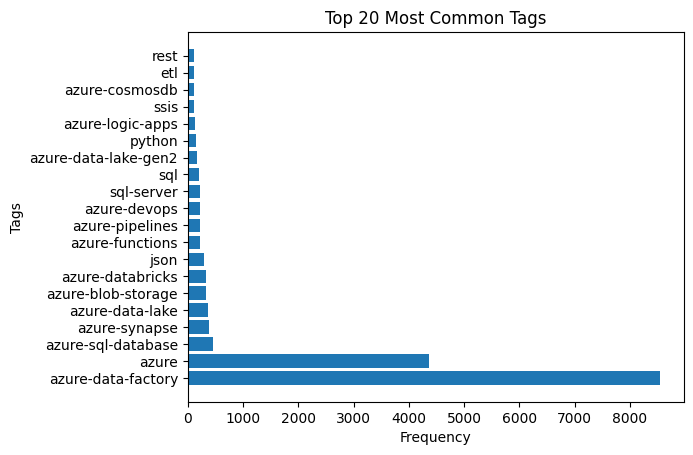

In [19]:
# Analyze the most common tags:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
tags = df['QuestionTags'].str.findall('<(.*?)>').explode().values
tag_counts = Counter(tags)
most_common_tags = tag_counts.most_common(20)

plt.barh([tag for tag, _ in most_common_tags], [count for _, count in most_common_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Common Tags')
plt.show()

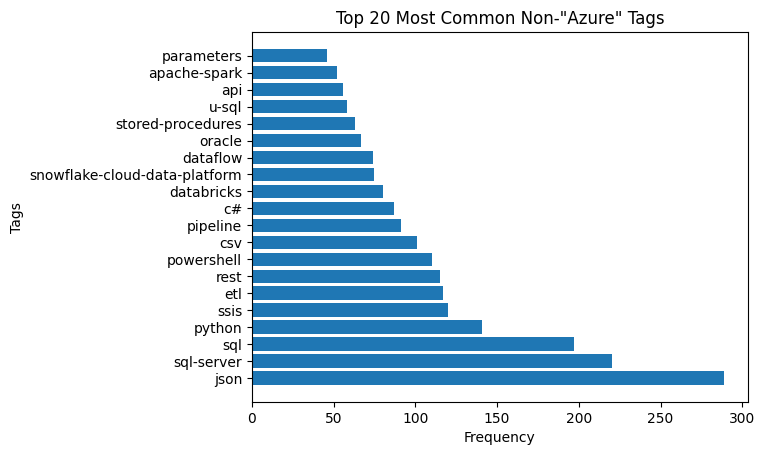

In [20]:
# Analyze the most common non-azure tags:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Assuming you already have a DataFrame called 'df'

# Find and extract tags
df['SplitTags'] = df['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 20 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(20)

plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Common Non-"Azure" Tags')
plt.show()

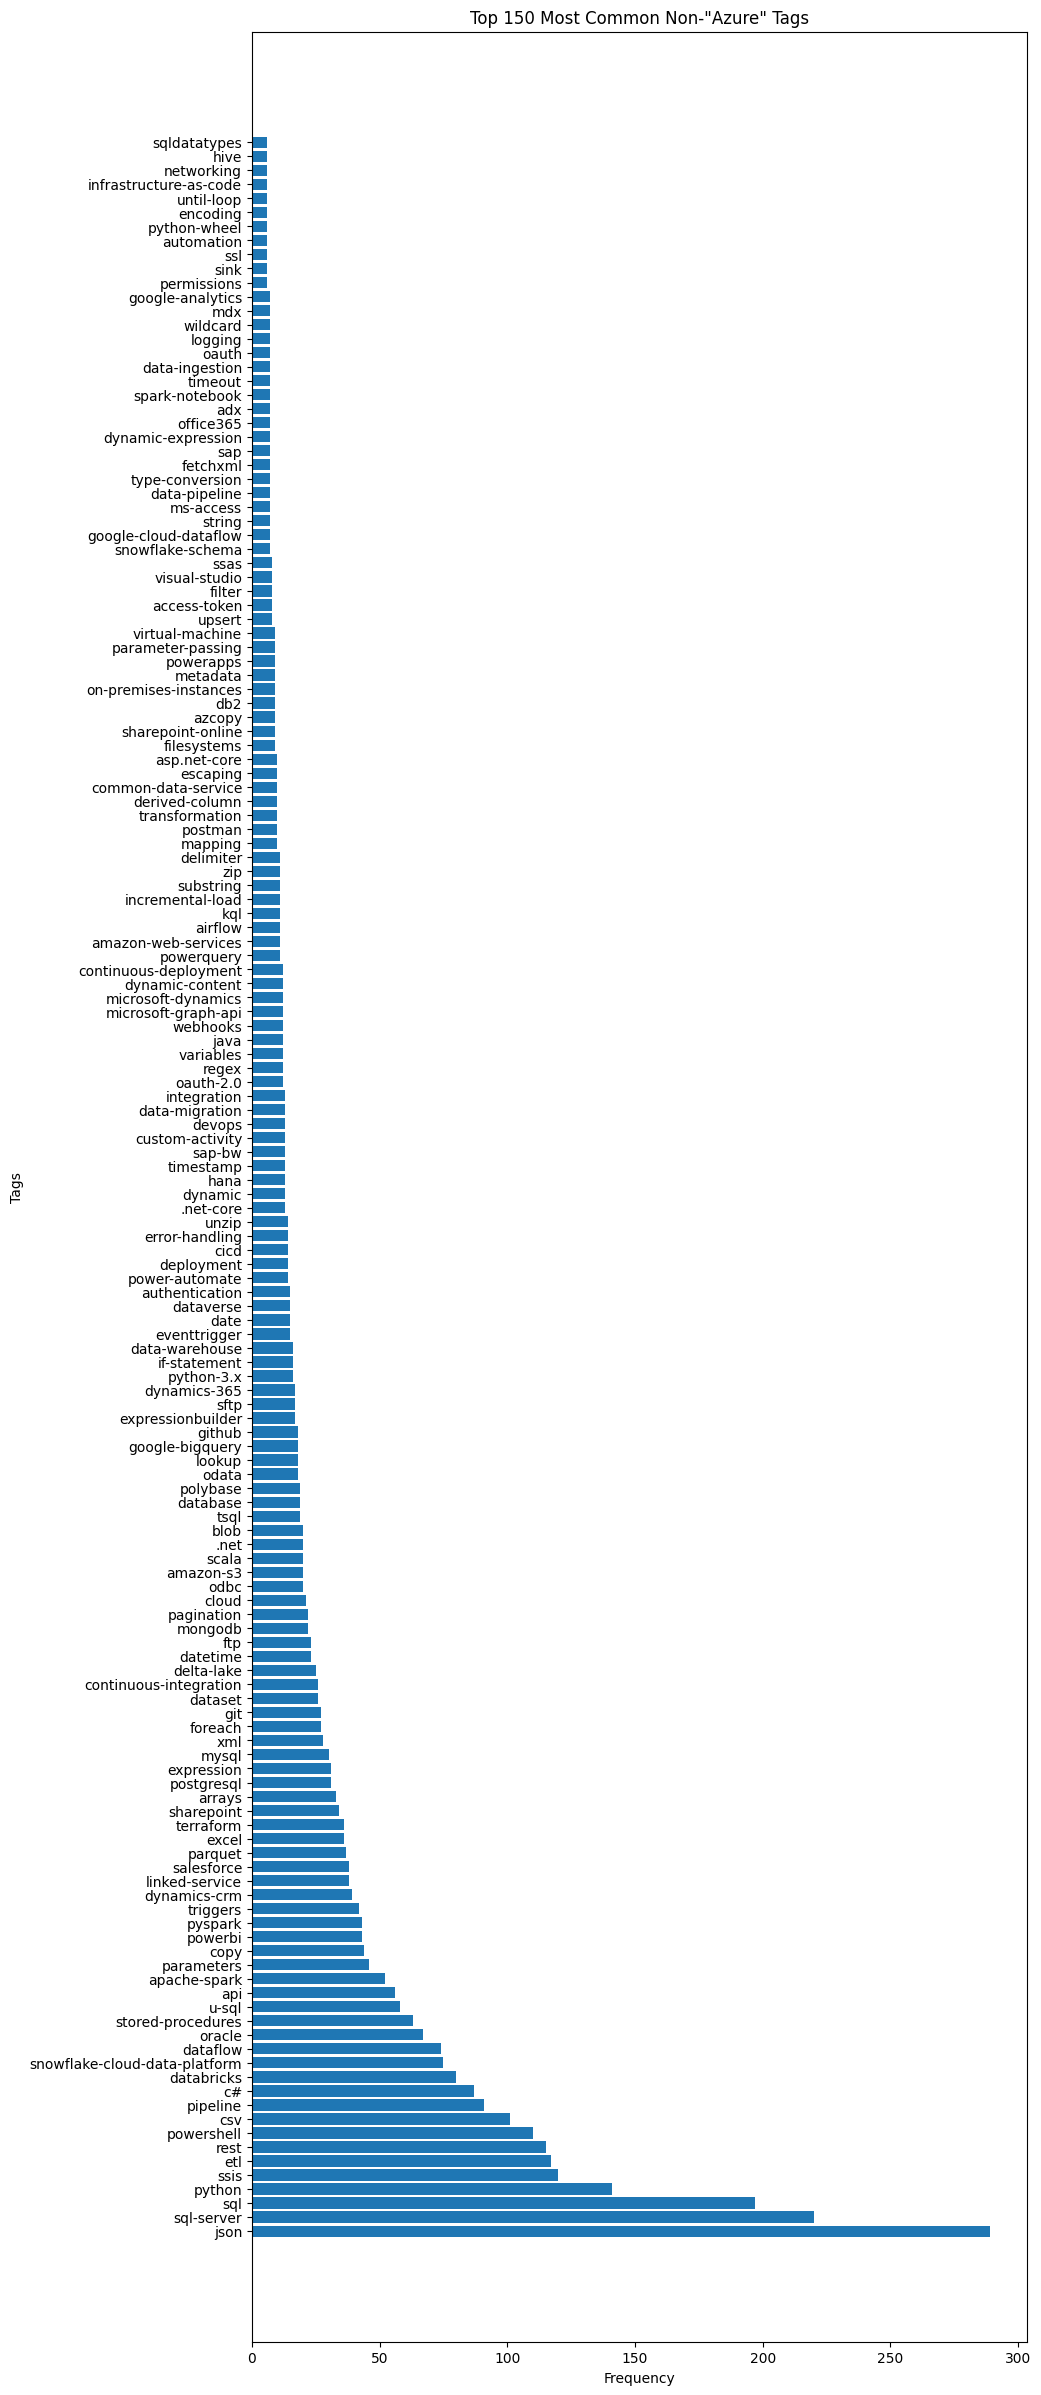

List of the top 150 non-'Azure' tags:
['json', 'sql-server', 'sql', 'python', 'ssis', 'etl', 'rest', 'powershell', 'csv', 'pipeline', 'c#', 'databricks', 'snowflake-cloud-data-platform', 'dataflow', 'oracle', 'stored-procedures', 'u-sql', 'api', 'apache-spark', 'parameters', 'copy', 'powerbi', 'pyspark', 'triggers', 'dynamics-crm', 'linked-service', 'salesforce', 'parquet', 'excel', 'terraform', 'sharepoint', 'arrays', 'postgresql', 'expression', 'mysql', 'xml', 'foreach', 'git', 'dataset', 'continuous-integration', 'delta-lake', 'datetime', 'ftp', 'mongodb', 'pagination', 'cloud', 'odbc', 'amazon-s3', 'scala', '.net', 'blob', 'tsql', 'database', 'polybase', 'odata', 'lookup', 'google-bigquery', 'github', 'expressionbuilder', 'sftp', 'dynamics-365', 'python-3.x', 'if-statement', 'data-warehouse', 'eventtrigger', 'date', 'dataverse', 'authentication', 'power-automate', 'deployment', 'cicd', 'error-handling', 'unzip', '.net-core', 'dynamic', 'hana', 'timestamp', 'sap-bw', 'custom-activit

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Find and extract tags
df['SplitTags'] = df['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 150 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(150)

plt.figure(figsize=(10, 30))  # Adjust the plot size for better visibility
plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 150 Most Common Non-"Azure" Tags')
plt.show()

# Print the list of the top 150 non-"azure" tags
top_150_tags = [tag for tag, _ in most_common_non_azure_tags]
print("List of the top 150 non-'Azure' tags:")
print(top_150_tags)

**Analysis: Tags which might indicate requirement engineering processes:**

Pipeline

dataflow

api

Parameters

Triggers
xml

continous integration?

cloud

blob?

eventtrigger

data-migration

integration

dynamic content

custom activity

incremental load

mapping

transformation

metadata

snowflake-schema

data-pipline

data-ingestions

automation


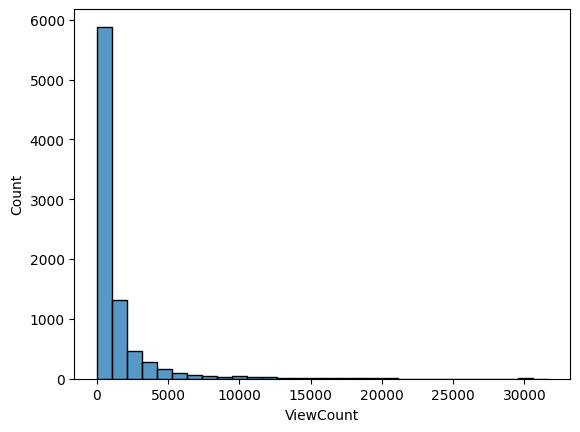

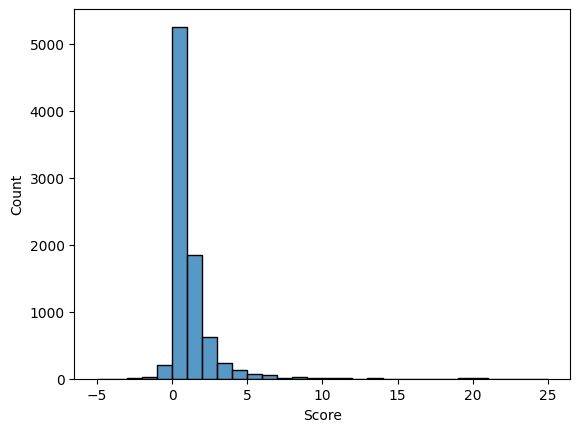

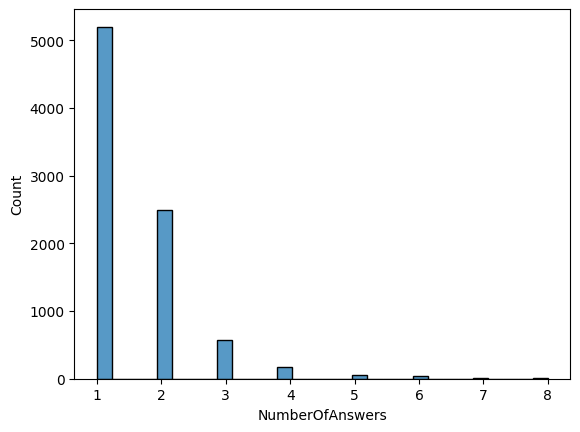

In [22]:
# Visualize the distribution of ViewCount, Score, and NumberOfAnswers:
#!pip install seaborn

sns.histplot(data=df, x='ViewCount', bins=30)
plt.show()

sns.histplot(data=df, x='Score', bins=30)
plt.show()

sns.histplot(data=df, x='NumberOfAnswers', bins=30)
plt.show()

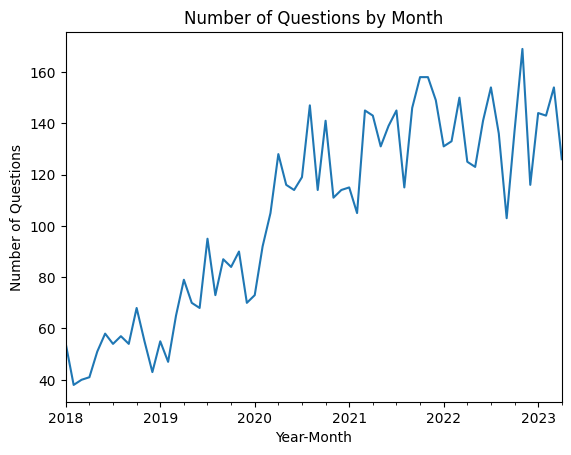

In [23]:
# Analyze the distribution of questions over time:

df['YearMonth'] = df['Date'].dt.to_period('M')

question_count_by_month = df.groupby('YearMonth')['QuestionId'].nunique()
question_count_by_month.plot()
plt.xlabel('Year-Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions by Month')
plt.show()

**NLP-Pre-Processing**

_always do:_ lowercasing, removal of non-alphanumeric characters

_depends on task and corpus_: stopwords removal, lemmatization (for spaCy stopwords have to be removed)


***Clean the Data using BeautifulSoup and Regex***

Use BeautifulSoup to clean the question and answer body. Remove any HTML tags present in the text. 

These tags don't provide any valuable information for most NLP tasks and can be considered noise in the text data.

In [24]:
from bs4 import BeautifulSoup

df['CleanedQuestionBody'] = df['QuestionBody'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
df['CleanedAnswerBody'] = df['AnswerBody'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

In [25]:
# Regex: Remove any unnecessary characters, such as punctuation, numbers, or extra whitespace, 
# and convert the text to lowercase:

import re

def clean_text(text):
    text = re.sub(r'\W+', ' ', text)  # Remove non-word characters
    text = re.sub(r'\d+', ' ', text)  # Remove digits
    text = text.lower().strip()  # Convert to lowercase and remove leading/trailing whitespace
    text = text.replace('<code>', '').replace('</code>', '')  # Remove <code> tags
    return text

df['CleanedQuestionBody'] = df['CleanedQuestionBody'].apply(clean_text)
df['CleanedAnswerBody'] = df['CleanedAnswerBody'].apply(clean_text)

# The answer bodies are pre-processed but will not be part of the NLP analysis for this project

In [26]:
# Create a new column of cleaned tags with no <code> tags:
df['Tags'] = df['QuestionTags'].str.findall('<(.*?)>')

In [27]:
# lower the question titles
df['QuestionTitle'].apply(lambda x: x.lower())

0       filter to copy specific sets of data using azu...
1       automatically navigated to the specific branch...
2       what compression type should we choose to unzi...
3       how to change the type, to an array, of an ite...
4       whats the easiest way to extract all columns f...
                              ...                        
8542    azure data factory start pipeline different fr...
8543    connect to sql data warehouse from hdinsight o...
8544                        azure df copyfromblob failing
8545    fault tolerance in copy activity by skipping i...
8546    azure data factory - write result of pipeline ...
Name: QuestionTitle, Length: 8547, dtype: object

In [28]:
import string

# Replace punctuation in the titles with spaces
translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
df['QuestionTitle'] = df['QuestionTitle'].str.translate(translator)

# Remove tags in the title
df['TagsInTitle'] = df['QuestionTitle'].str.findall('<(.*?)>')

In [29]:
df['QuestionTitle'].head(10)

0    Filter to copy specific sets of data using Azu...
1    Automatically navigated to the specific branch...
2    What compression type should we choose to unzi...
3    How to change the type  to an array  of an ite...
4    Whats the Easiest Way to Extract All Columns F...
5    Azure data factory Error   InvalidTemplate  Er...
6    How to add a new column with non default delim...
7    How to Replicate the mentioned Logic in Azure ...
8    ADF Pipeline to delete certain folders subfold...
9    Create dynamic folders and sub folders inside ...
Name: QuestionTitle, dtype: object

Cleaned titles are not saved in an new column as they will not be part of further NLP processing. 
They will be used for keyword counting only.  

In [30]:
df.head(2)

,QuestionId,QuestionTitle,QuestionBody,QuestionTags,Date,ViewCount,Score,NumberOfAnswers,AnswerId,AnswerBody,SplitTags,YearMonth,CleanedQuestionBody,CleanedAnswerBody,Tags,TagsInTitle
0,76138907,Filter to copy specific sets of data using Azu...,<p>I am starting to learn about Azure Data Fac...,<azure><azure-data-factory><replication><datab...,2023-04-29 23:24:38,12,0,1,76139010,<p>You can definitely use <code>Copy Data</cod...,"[azure, azure-data-factory, replication, datab...",2023-04,i am starting to learn about azure data factor...,you can definitely use copy data tool to speci...,"[azure, azure-data-factory, replication, datab...",[]
1,76133214,Automatically navigated to the specific branch...,<p>I have already setup Git repository and it ...,<azure><azure-data-factory>,2023-04-28 20:53:01,18,0,1,76133652,<p>You don't think you can reach to a specific...,"[azure, azure-data-factory]",2023-04,i have already setup git repository and it con...,you don t think you can reach to a specific br...,"[azure, azure-data-factory]",[]


In [31]:
# Check new columns

column_names = df.columns
print(column_names)

Index(['QuestionId', 'QuestionTitle', 'QuestionBody', 'QuestionTags', 'Date',
       'ViewCount', 'Score', 'NumberOfAnswers', 'AnswerId', 'AnswerBody',
       'SplitTags', 'YearMonth', 'CleanedQuestionBody', 'CleanedAnswerBody',
       'Tags', 'TagsInTitle'],
      dtype='object')


***Tokenization and Lemmatization***

In [32]:
# Tokenization (split text into individual words)

from nltk.tokenize import word_tokenize

df['TokenizedQuestionBody'] = df['CleanedQuestionBody'].apply(word_tokenize)
df['TokenizedAnswerBody'] = df['CleanedAnswerBody'].apply(word_tokenize)

In [33]:
# Lemmatization (reduce words to their lemma)

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df['LemmatizedQuestionBody'] = df['TokenizedQuestionBody'].apply(lemmatize_tokens)
df['LemmatizedAnswerBody'] = df['TokenizedAnswerBody'].apply(lemmatize_tokens)

In [34]:
# Remove stopwords from the 'LemmatizedQuestionBody' column:

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['LemmatizedQuestionBody'] = df['LemmatizedQuestionBody'].apply(remove_stopwords)

In [35]:
# Save pre-processed data for usage in further notebooks

#adf_query_lemmatized = df.to_csv('adf_query_lemmatized.csv', index=True)

**Wordcloud and Extractions with spaCy**

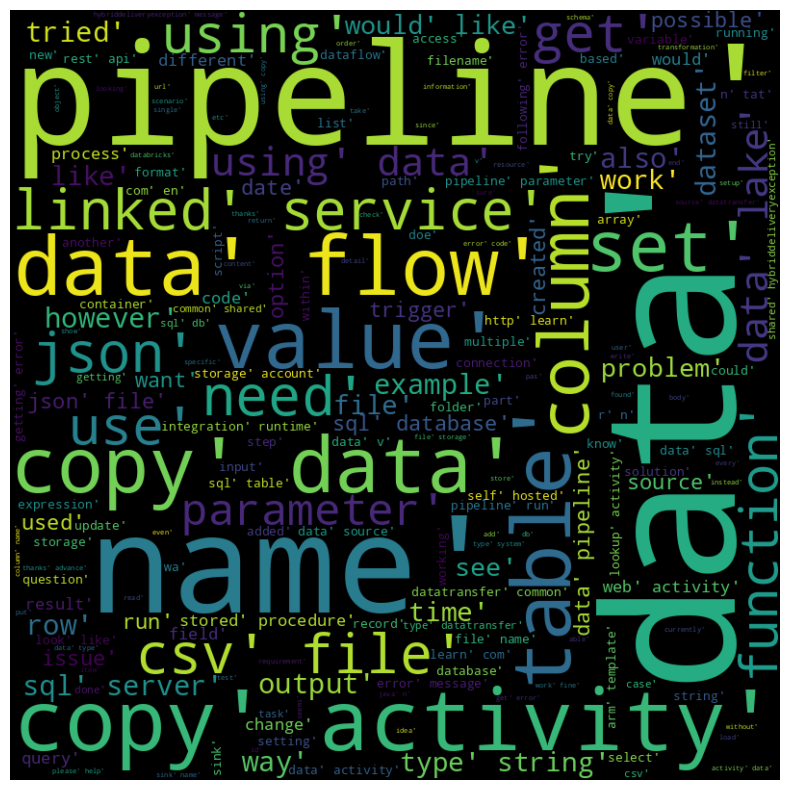

In [36]:
import spacy
import re
from wordcloud import WordCloud, STOPWORDS

# Define stop_words and stop_phrases separately
stop_words = {'adf', 'azure', 'ha', 'microsoft', 'blob', 'factory', 'one', 'two', 
              'first', 'second', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u'
             }
stop_phrases = {'azure data', 'data factory', 'u u', 'azure data factory', 'azure pipeline', 'azure synapse', 
                  'azure sql database', 'azure data lake', 'azure blob storage', 'azure databricks', 'azure devops'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Load the English language model
nlp = spacy.load('en_core_web_lg')

# Combine all the preprocessed texts into a single string
preprocessed_texts = ' '.join(df['LemmatizedQuestionBody'].astype(str))

# Remove stop words and stop phrases from the preprocessed_texts
for stopword in all_stop_words:
    preprocessed_texts = re.sub(r'\b' + re.escape(stopword) + r'\b', '', preprocessed_texts, flags=re.IGNORECASE)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800)

# Generate the word cloud with a larger size (e.g., 800x800) and the preprocessed_texts without stopwords
cloud = wordcloud.generate(preprocessed_texts.lower())

# Display the word cloud
plt.figure(figsize=(10, 10))  # Increase the figure size for better visibility
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [37]:
from collections import defaultdict

# Define stop words and stop phrases
stop_words = {'microsoft', 'factory', 'one', 'u u', 'two', 
              'first', 'second', 'azure', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 'azure data', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u', 
              'europe', 'ec', 'tenant_id', 'thousand', 'yesterday',
              'adl', 'jan', 'monthly', 'to_date', 'subscription_id', 'created'
             }
stop_phrases = {'azure data', 'data factory', 'u u'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Analyze the text and extract entities, nouns, and verbs
entities_counter = defaultdict(int)
nouns_counter = defaultdict(int)
verbs_counter = defaultdict(int)

for _, row in df.iterrows():
    question_body = row['LemmatizedQuestionBody']

    question_body = ' '.join(question_body)

    # Remove stop words and stop phrases from the question_body
    for stopword in all_stop_words:
        question_body = re.sub(r'\b' + re.escape(stopword) + r'\b', '', question_body, flags=re.IGNORECASE)
    
    doc = nlp(question_body)
        
    for ent in doc.ents:
        if ent.text.lower() not in stop_words:
            entities_counter[ent.text.lower()] += 1
        
    for token in doc:
        if token.pos_ == 'NOUN' and token.is_alpha and token.text.lower() not in stop_words:
            nouns_counter[token.text.lower()] += 1
        elif token.pos_ == 'VERB' and token.is_alpha and token.text.lower() not in stop_words:
            verbs_counter[token.text.lower()] += 1

# Display the top 10 most common entities, nouns, and verbs
def display_top_n(counter, n, title):
    print(title)
    for item, count in sorted(counter.items(), key=lambda x: x[1], reverse=True)[:n]:
        print(f"{item}: {count}")
    print()

display_top_n(entities_counter, 10, "Top 10 Entities")
display_top_n(nouns_counter, 10, "Top 10 Nouns")
display_top_n(verbs_counter, 10, "Top 10 Verbs")

Top 10 Entities
netty: 80
delta: 76
sdk: 76
az: 63
rdd: 59
formatdatetime: 52
json data: 49
api: 41
zero: 40
netty handler: 40

Top 10 Nouns
data: 10067
file: 9012
pipeline: 7668
activity: 7257
type: 6103
name: 5038
error: 5004
source: 4894
table: 4774
value: 4416

Top 10 Verbs
using: 5295
get: 3163
want: 2376
trying: 2001
tried: 1886
set: 1842
run: 1733
create: 1726
use: 1670
following: 1528



**Latent Dirichlet Allocation**

In [38]:
import numpy as np
import random
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Set the random seed for numpy and python to ensure the same results each time the allocation re-runs
np.random.seed(42)
random.seed(42)

# Prepare the input data by using the lemmatized tokens from the 'LemmatizedQuestionBody' column:
documents = df['LemmatizedQuestionBody'].tolist()

# Create a dictionary and a bag of words corpus from the documents:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Set the seed for the random number generator used by the LDA model to a fixed value. 
# Ensures that the same sequence of random numbers is generated every time the model is trained 
# with the same input data and configuration.
random_state_seed = 42 
gensim.models.ldamodel.LdaModel.seed = random_state_seed

# Train the LDA model.  
# Set number of topics by setting the num_topics parameter:
num_topics = 10  
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15) # Set the number of passes

# Display the top words for each topic
words_per_topic = 10  # Specify the number of top words per topic
for topic in range(num_topics):
    print(f"Topic {topic + 1}:")
    top_words = lda_model.show_topic(topic, topn=words_per_topic)
    for word, weight in top_words:
        print(f"  {word}: {weight:.4f}")
    print()

Topic 1:
  data: 0.0446
  file: 0.0403
  azure: 0.0361
  pipeline: 0.0263
  factory: 0.0211
  blob: 0.0138
  activity: 0.0130
  using: 0.0130
  storage: 0.0111
  copy: 0.0110

Topic 2:
  factory: 0.0291
  azure: 0.0226
  pipeline: 0.0206
  new: 0.0160
  data: 0.0156
  datafactory: 0.0128
  resource: 0.0122
  adf: 0.0122
  mm: 0.0122
  template: 0.0117

Topic 3:
  api: 0.0283
  json: 0.0246
  http: 0.0216
  data: 0.0207
  url: 0.0174
  web: 0.0171
  activity: 0.0169
  rest: 0.0149
  get: 0.0140
  azure: 0.0132

Topic 4:
  type: 0.0642
  name: 0.0517
  activity: 0.0430
  parameter: 0.0333
  pipeline: 0.0275
  value: 0.0249
  output: 0.0227
  string: 0.0173
  false: 0.0155
  item: 0.0149

Topic 5:
  n: 0.1280
  r: 0.0544
  procedure: 0.0486
  stored: 0.0356
  module: 0.0133
  tat: 0.0124
  null: 0.0112
  dbo: 0.0106
  j: 0.0098
  io: 0.0094

Topic 6:
  u: 0.2821
  java: 0.0244
  com: 0.0216
  microsoft: 0.0191
  spark: 0.0178
  org: 0.0163
  apache: 0.0155
  scala: 0.0129
  package: 0.012

In [39]:
import numpy as np

# Get the document-topic matrix and pad with zeros if necessary 
# (lists inside doc_topic_matrix have different lengths.)
doc_topic_matrix = [np.pad([topic_prob for _, topic_prob in lda_model.get_document_topics(bow)], (0, lda_model.num_topics - len(lda_model.get_document_topics(bow))), mode='constant') for bow in corpus]

# Create a new column in the dataset to store the topic names
df['LDATopicName'] = ''

# Define a function that returns the topic name based on the index
def get_topic_name(topic_index):
    topic_names = {
        0: 'Topic1',
        1: 'Topic2',
        2: 'Topic3',
        3: 'Topic4',
        4: 'Topic5',
        5: 'Topic6',
        6: 'Topic7',
        7: 'Topic8',
        8: 'Topic9',
        9: 'Topic10',
    }
    return topic_names.get(topic_index, '')

# Iterate through the document-topic matrix and assign the topic names
for i, row in enumerate(doc_topic_matrix):
    topic_index = np.argmax(row)
    df.at[i, 'LDATopicName'] = get_topic_name(topic_index)

# This code block assumes that you have the `lda_model`, `corpus`, and `df` 
# variables defined in your environment. After running this code, your DataFrame 
# `df` should have a new column called `TopicName` with the assigned 
# topic names for each document.

#In this code, I've added a padding step using np.pad() to make all lists inside doc_topic_matrix 
#have the same length. This should resolve the warning, and the code should now work correctly in your 
#Jupyter Notebook."""

In [40]:
# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

df['LDATopic'] = df['LemmatizedQuestionBody'].apply(assign_topic)

**Perform Sentiment Analysis on each topic**

In [41]:
# The VADER sentiment analyzer is designed especially for sentiment analysis on social media texts 
# Use raw, unprocessed text the way it comes out of social media.

import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate the sentiment scores
def get_sentiment_score(text):
    return sia.polarity_scores(text)

# Apply the function to the 'QuestionBody' column and store the sentiment scores in a new column
df['VaderSentimentScores'] = df['QuestionBody'].apply(get_sentiment_score)

# Calculate the average sentiment score for each topic
avg_sentiment_by_topic = df.groupby('LDATopicName')['VaderSentimentScores'].apply(lambda scores: pd.DataFrame(scores.tolist()).mean())

print(avg_sentiment_by_topic)



LDATopicName          
Topic1        neg         0.026175
              neu         0.911859
              pos         0.061982
              compound    0.258191
Topic10       neg         0.109000
              neu         0.749000
              pos         0.142000
              compound    0.833500
Topic2        neg         0.027381
              neu         0.910406
              pos         0.062205
              compound    0.263331
Topic3        neg         0.030278
              neu         0.906989
              pos         0.062736
              compound    0.281181
Topic4        neg         0.037211
              neu         0.906508
              pos         0.056260
              compound    0.174327
Topic5        neg         0.049029
              neu         0.894843
              pos         0.056187
              compound    0.088480
Topic6        neg         0.056958
              neu         0.885653
              pos         0.057305
              compound    0.0017

In [ ]:
df.head(2)

C:\Users\TanjaWolf_7ms6v6m\AppData\Local\Temp\ipykernel_16380\3735487988.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_df2['Tags'] = df_filtered_df2['Tags'].apply(lambda x: ', '.join(x) if isinstance(x, tuple) else x)


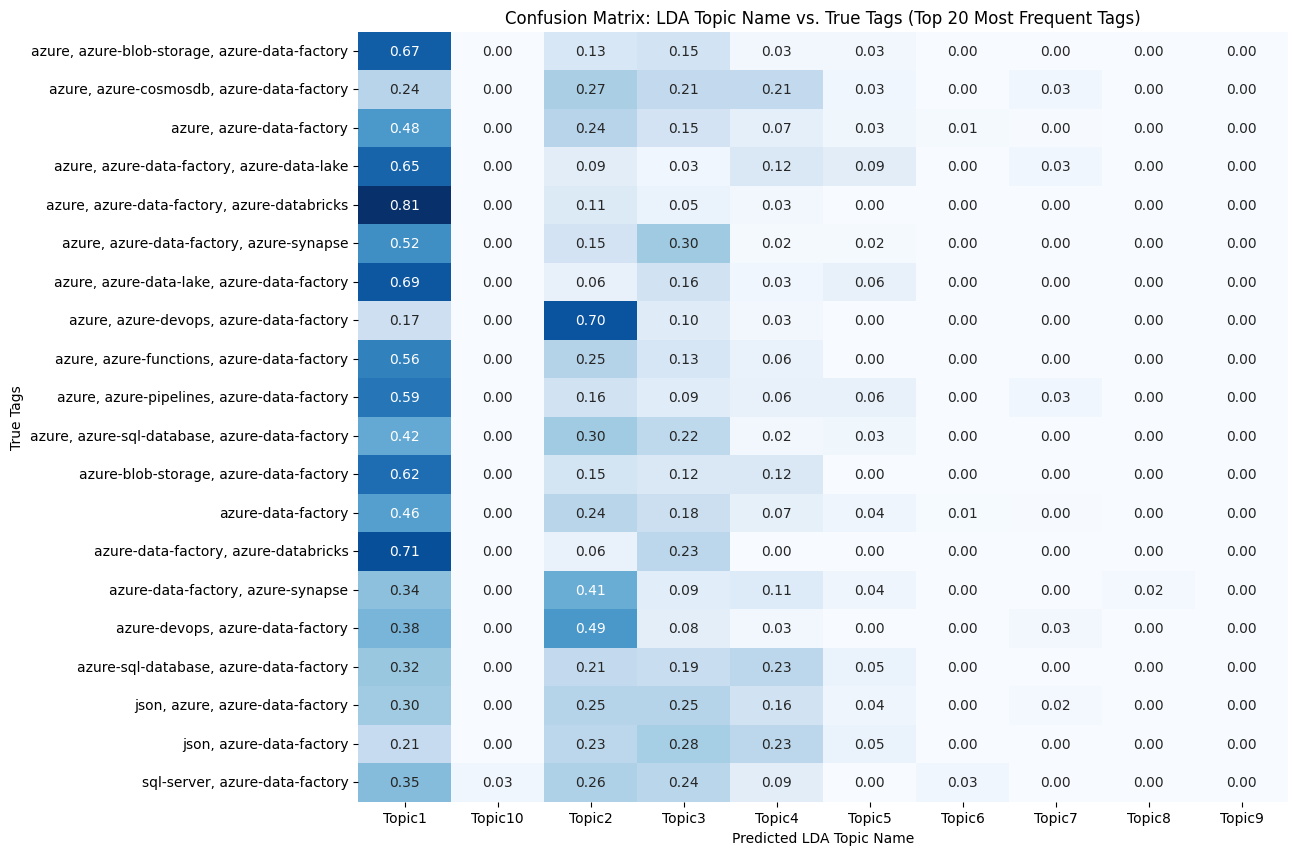

In [48]:
df_top_n_tags = 20

# Create a copy of the dataframe and convert lists in 'Tags' column to tuples
df_copy = df.copy()
df_copy['Tags'] = df_copy['Tags'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Get the top N most frequent tags
df_top_tags = df_copy['Tags'].value_counts().nlargest(df_top_n_tags).index.tolist()

# Filter the dataset
df_filtered_df2 = df_copy[df_copy['Tags'].isin(df_top_tags)]

df_filtered_df2['Tags'] = df_filtered_df2['Tags'].apply(lambda x: ', '.join(x) if isinstance(x, tuple) else x)
confusion_matrix = pd.crosstab(df_filtered_df2['Tags'], df_filtered_df2['LDATopicName'])

# Create a confusion matrix
confusion_matrix = pd.crosstab(df_filtered_df2['Tags'], df_filtered_df2['LDATopicName'])

# Normalize the confusion matrix by row to show proportions
df_normalized_confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)

plt.figure(figsize=(12, 10))
sns.heatmap(df_normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)

plt.xlabel('Predicted LDA Topic Name')
plt.ylabel('True Tags')
plt.title('Confusion Matrix: LDA Topic Name vs. True Tags (Top {} Most Frequent Tags)'.format(df_top_n_tags))
plt.show()

_Result:_ The comparison of tags and topics reveals that there seems to be only one very strong topic where tags an topics match.


**Search for tags and keywords within the title and question body**

1) search for tags and keywords from the preceding queriesregarding requirements 
Engineering, PIM, Master Data Management, Data Warehouse, data governance
Keywords are derived from tags, Spacy extractions and LDA

2) include tags and keywords from this query
Keywords are derived from tags, Spacy extractions and LDA

**Search for Tags**

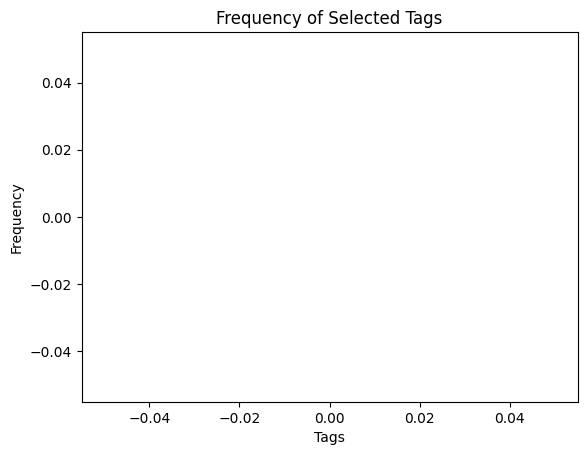

In [69]:
# Search for relevant tags from previous requirements engineering data set:

# Replace with the relvant tags 
tags_to_plot = ['user', 'use-case', 'specifications', 'system-requirements', 'use-case-diagram', 'requirements', 'requirements', 'catalog', 'system-requirements', 'use-case', 'requirements', 'specifications', 'requirements', 'use-case', 'modeling','use-case-diagram', 'diagram', 'scenarios']

# Filter the tags based on their presence in the dataset
tags_to_plot = [tag for tag in tags_to_plot if tag in unique_tags]

# Count the occurrences of each tag
tag_counts = {tag: df['Tags'].apply(lambda tags: tag in tags).sum() for tag in tags_to_plot}

# Create a bar plot
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Tags')
plt.show()

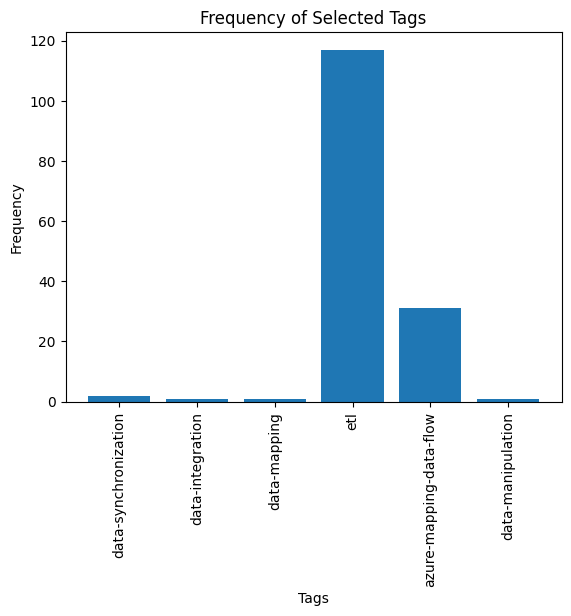

In [70]:
# Search for relevant tags from mdm, warehouse, corporate governance data set:
tags_to_plot = ['mdm', 'data-synchronization', 'data-integration', 'data-mapping',
    'etl', 'azure-mapping-data-flow', 'dataflow-diagram', 'data-manipulation',
    'azure data factory', 'master-data-management', 'product data management',
    'product data', 'product data management', 'data modelling', 'dimensional modelling',
    'star schema', 'data quality', 'buisness intelligence', 'data-mapping',
    'data-manipulation', 'data Transformation', 'data flow',
]

# Filter the tags based on their presence in the dataset
tags_to_plot = [tag for tag in tags_to_plot if tag in unique_tags]

# Count the occurrences of each tag
tag_counts = {tag: df['Tags'].apply(lambda tags: tag in tags).sum() for tag in tags_to_plot}

# Create a bar plot
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Tags')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

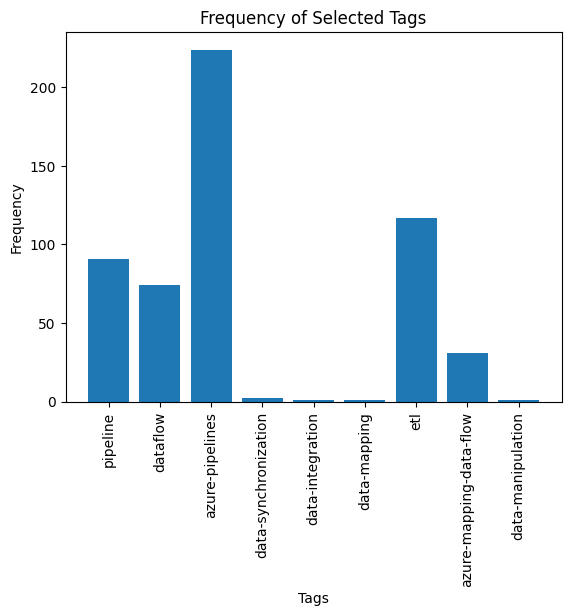

In [71]:
# Add relevant tags from this data set:
tags_to_plot = ['pipeline','dataflow','azure-pipelines', 'mdm', 'data-synchronization', 'data-integration', 'data-mapping',
    'etl', 'azure-mapping-data-flow', 'dataflow-diagram', 'data-manipulation',
    'azure data factory', 'master-data-management', 'product data management',
    'product data', 'product data management', 'data modelling', 'dimensional modelling',
    'star schema', 'data quality', 'buisness intelligence', 'data-mapping',
    'data-manipulation', 'data Transformation', 'data flow', 
]

# Filter the tags based on their presence in the dataset
tags_to_plot = [tag for tag in tags_to_plot if tag in unique_tags]

# Count the occurrences of each tag
tag_counts = {tag: df['Tags'].apply(lambda tags: tag in tags).sum() for tag in tags_to_plot}

# Create a bar plot
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Tags')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

**Search for Keywords**

**Keywords in the title**

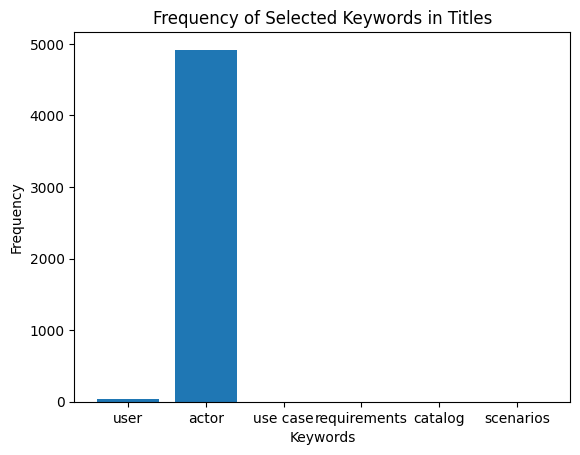

In [72]:
# Relevant keywords from previous requirements engineering data sets:

keywords_to_plot = ['user','actor','use case', 'specifications', 'system requirements', 'use case diagram', 'requirements', 'requirements', 'catalog', 'system requirements', 'specifications', 'modeling', 'diagram', 'scenarios']

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df['QuestionTitle'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df['QuestionTitle'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Titles')
plt.show()

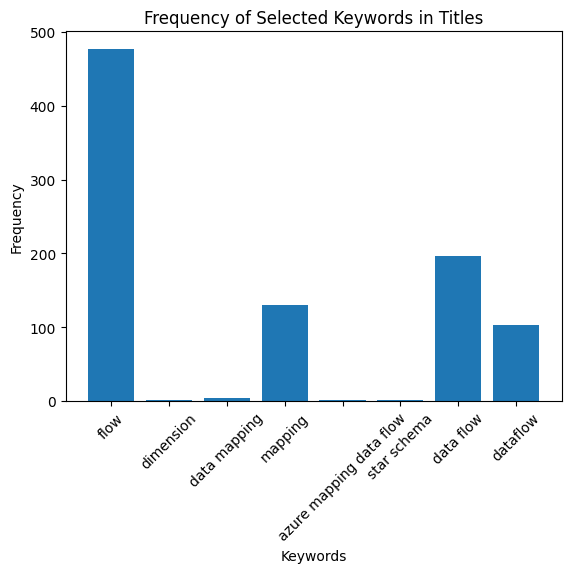

In [73]:
# relevant keywords from previous mdm, warehouse, corporate governance data set: 

keywords_to_plot = ['flow', 'dimension', 'dimension modelling', 'mdm', 'data synchronization', 'data integration', 'data mapping', 'mapping', 'etl', 'azure mapping data flow', 'dataflow diagram', 'data manipulation',
    'master data management', 'product data management',
    'product data', 'product data management', 'data modelling', 'dimensional modelling',
    'star schema', 'data quality', 'buisness intelligence', 'data mapping',
    'data manipulation', 'data Transformation', 'data flow', 'dataflow'
]

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df['QuestionTitle'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df['QuestionTitle'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Titles')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Insert Keywords from this query**

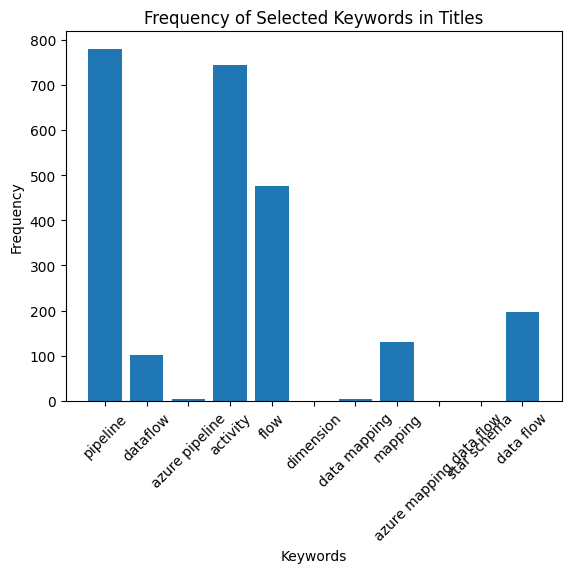

In [74]:
# Relevant keywords from this data set:

keywords_to_plot = ['pipeline', 'dataflow', 'azure pipeline', 'activity', 'flow', 'dimension', 'dimension modelling', 'mdm', 'data synchronization', 'data integration', 'data mapping', 'mapping', 'etl', 'azure mapping data flow', 'dataflow diagram', 'data manipulation',
    'master data management', 'product data management',
    'product data', 'product data management', 'data modelling', 'dimensional modelling',
    'star schema', 'data quality', 'buisness intelligence', 'data mapping',
    'data manipulation', 'data Transformation', 'data flow', 
]

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df['QuestionTitle'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df['QuestionTitle'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Titles')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Keywords in the question**

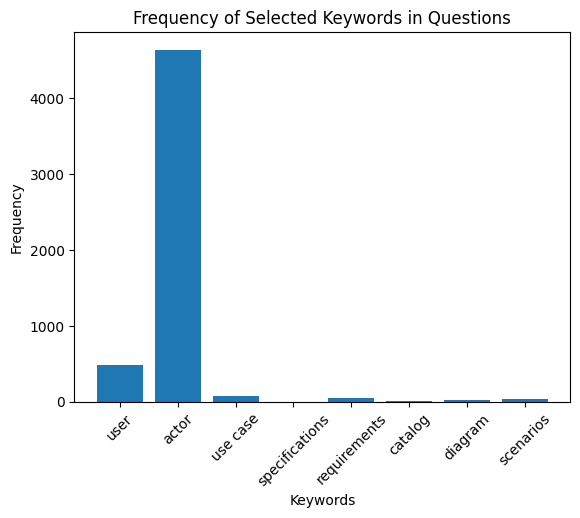

In [76]:
# Relevant keywords from previous requirements engineering data sets:

keywords_to_plot = ['user','actor','use case', 'specifications', 'system requirements', 'use case diagram', 'requirements', 'requirements', 'catalog', 'system requirements', 'specifications', 'modeling', 'diagram', 'scenarios']

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df['QuestionBody'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df['QuestionBody'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Questions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

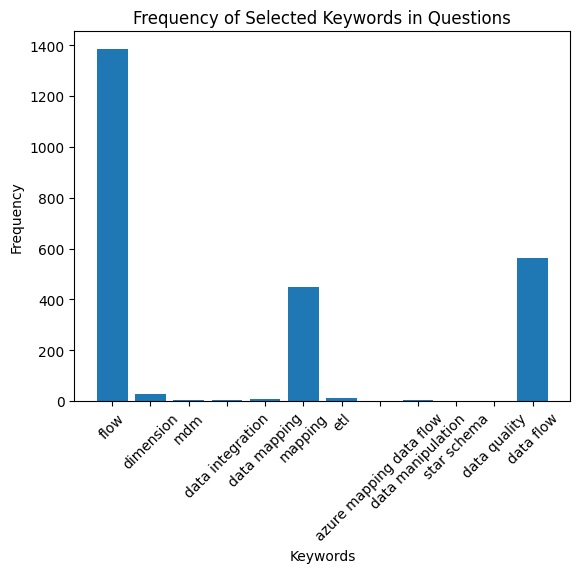

In [77]:
# relevant keywords from previous mdm, warehouse, corporate governance data set: 

keywords_to_plot = ['flow', 'dimension', 'dimension modelling', 'mdm', 'data synchronization', 'data integration', 'data mapping', 'mapping', 'etl', 'azure mapping data flow', 'dataflow diagram', 'data manipulation',
    'master data management', 'product data management',
    'product data', 'product data management', 'data modelling', 'dimensional modelling',
    'star schema', 'data quality', 'buisness intelligence', 'data mapping',
    'data manipulation', 'data Transformation', 'data flow'
]

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df['QuestionBody'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df['QuestionBody'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Questions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

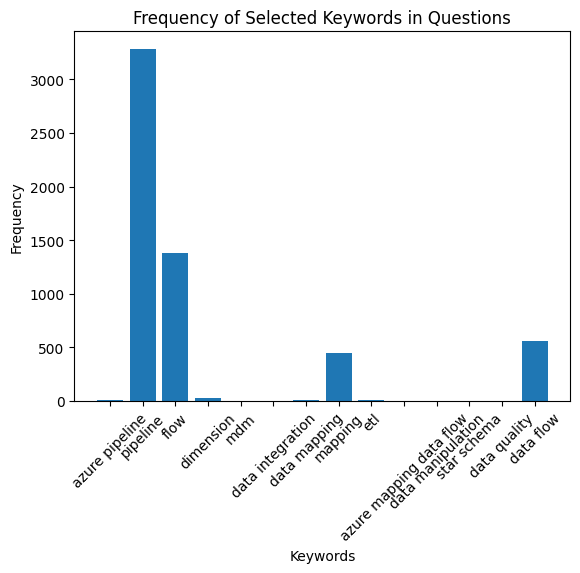

In [78]:
# Relevant keywords from this data set:

keywords_to_plot = ['azure pipeline', 'pipeline', 'dataflow' 'activity', 'flow', 'dimension', 'dimension modelling', 'mdm', 'data synchronization', 'data integration', 'data mapping', 'mapping', 'etl', 'azure mapping data flow', 'dataflow diagram', 'data manipulation',
    'master data management', 'product data management',
    'product data', 'product data management', 'data modelling', 'dimensional modelling',
    'star schema', 'data quality', 'buisness intelligence', 'data mapping',
    'data manipulation', 'data Transformation', 'data flow'
]

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df['QuestionBody'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df['QuestionBody'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Questions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Use verbs from previous queries to filter for azure questions concerning requirements engineering, MDM and data warehouse**

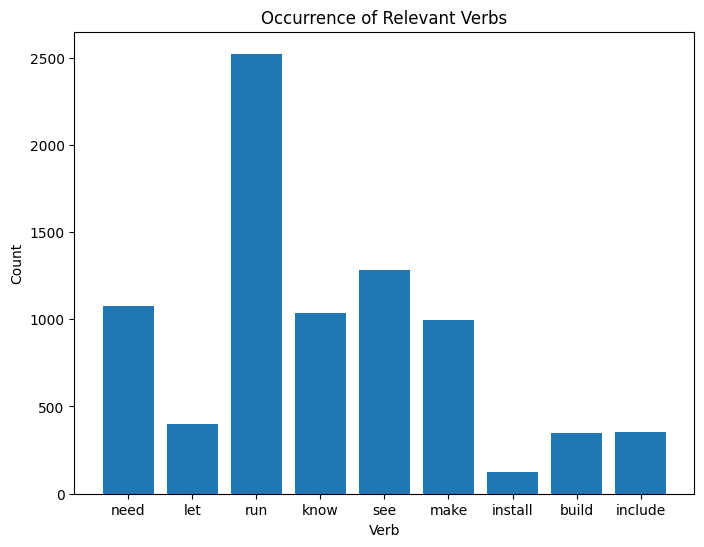

In [79]:
from collections import Counter

# List of relevant verbs which appeared as top10 verbs in previous data sets but did not appear as top10 in this data set.

relevant_verbs = ['need', 'make', 'know', 'include', 'build', 'install', 'run', 'let', 'see']

# Define a function to check if a question contains relevant verbs
def contains_relevant_verbs(question_body):
    # Convert the list of lemmatized tokens to a string
    question_text = ' '.join(question_body)
    doc = nlp(question_text)
    for token in doc:
        if token.lemma_ in relevant_verbs and token.pos_ == 'VERB':
            return True
    return False

# Filter the dataframe to only include questions that contain relevant verbs
relevant_questions = df[df['LemmatizedQuestionBody'].apply(contains_relevant_verbs)]

# Count the occurrence of each relevant verb
verb_counts = Counter()

for question in relevant_questions['LemmatizedQuestionBody']:
    # Convert the list of lemmatized tokens to a string
    question_text = ' '.join(question)
    doc = nlp(question_text)
    for token in doc:
        if token.lemma_ in relevant_verbs and token.pos_ == 'VERB':
            verb_counts[token.lemma_] += 1

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(verb_counts.keys(), verb_counts.values())
ax.set_title('Occurrence of Relevant Verbs')
ax.set_xlabel('Verb')
ax.set_ylabel('Count')
plt.show()

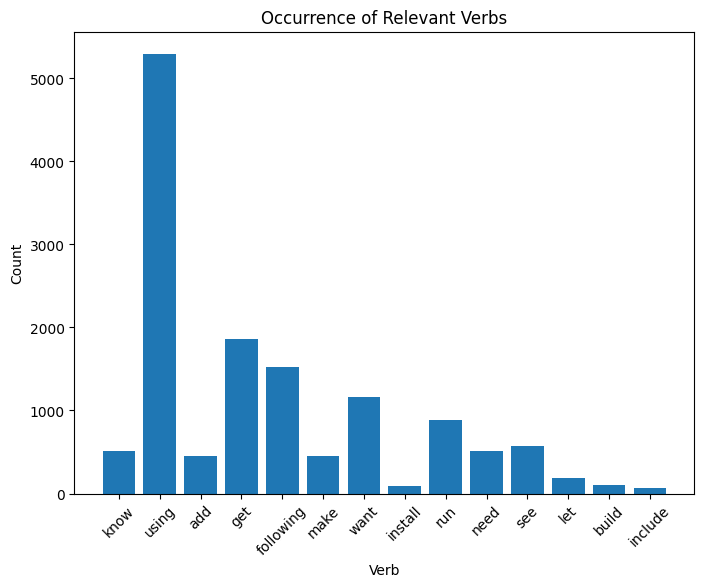

In [80]:
from collections import Counter

# Add relevant verbs which appear in as top10 verbs in this data set AND the prevoius data sets:
relevant_verbs = ['using', 'want', 'get', 'following', 'add',  'need', 'make', 'know', 'include', 'build', 'install', 'run', 'let', 'see']

# Define a function to check if a question contains relevant verbs
def contains_relevant_verbs(question_body):
    # Convert the list of lemmatized tokens to a string
    question_text = ' '.join(question_body)
    doc = nlp(question_text)
    for token in doc:
        if token.text in relevant_verbs and token.pos_ == 'VERB' and (token.tag_ == 'VBG' or token.text == 'using'):
            return True
    return False


# Filter the dataframe to only include questions that contain relevant verbs
relevant_questions = df[df['LemmatizedQuestionBody'].apply(contains_relevant_verbs)]

# Count the occurrence of each relevant verb
verb_counts = Counter()

for question in relevant_questions['LemmatizedQuestionBody']:
    # Convert the list of lemmatized tokens to a string
    question_text = ' '.join(question)
    doc = nlp(question_text)
    for token in doc:
        if token.text in relevant_verbs and token.pos_ == 'VERB':
            verb_counts[token.text] += 1

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(verb_counts.keys(), verb_counts.values())
ax.set_title('Occurrence of Relevant Verbs')
ax.set_xlabel('Verb')
ax.set_ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [59]:
len(df)

8547

In [90]:
import nltk
#nltk.download('punkt')

# Tokenize the `QuestionBody` column into sentences
sentences = []
for question in df['QuestionBody']:
    sentences.extend(nltk.sent_tokenize(question))

# Filter the sentences to count the ones that start with "I am using"
num_questions_starting_with_i = sum(1 for sentence in sentences if sentence.startswith('I'))

print(f"Number of questions starting with 'I': {num_questions_starting_with_i}")

Number of questions starting with 'I': 6971


In [91]:
filtered_questions = [question for question in df['TokenizedQuestionBody'] if len(question) > 2 and question[0] == 'i' and question[1] == 'am' and question[2] == 'using']

In [92]:
# Number of questions starting with "I am using"
len(filtered_questions)

198

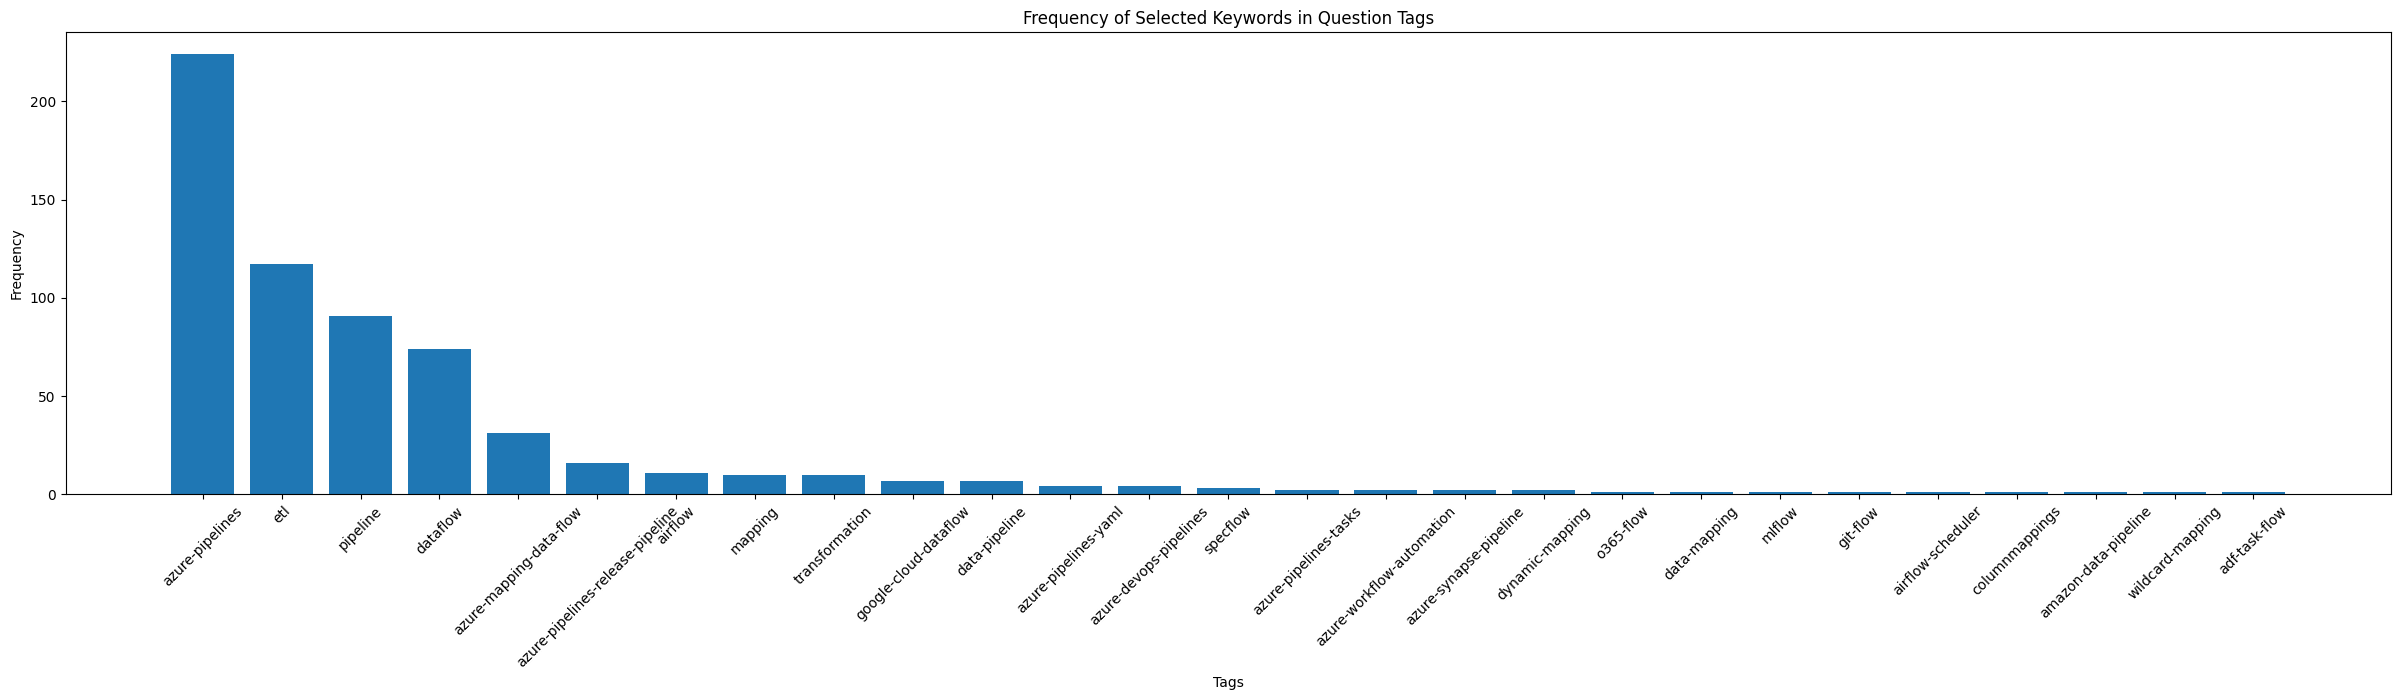

In [98]:
import matplotlib.pyplot as plt

# search tags for relevant nouns identified in previous data sets and in this data set.
keywords = ['dataflow', 'data flow', 'transformation', 'data transformation', 'azure mapping data flow',
            'mapping data flow', 'flow', 'pipeline', 'azure pipeline',
            'etl', 'data pipeline', 'following', 'data mapping',
            'mapping', 'data quality']

# Extract the tags that contain the keywords
tags_list = df['QuestionTags'].str.findall('<(.*?)>').explode().str.lower().str.strip()
filtered_tags = tags_list[tags_list.str.contains('|'.join(keywords))]

# Count the occurrences of each tag
tag_counts = filtered_tags.value_counts()

# Create a bar plot
plt.figure(figsize=(30,6))
plt.bar(tag_counts.index, tag_counts.values)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Question Tags')
plt.xticks(rotation=45)
plt.show()

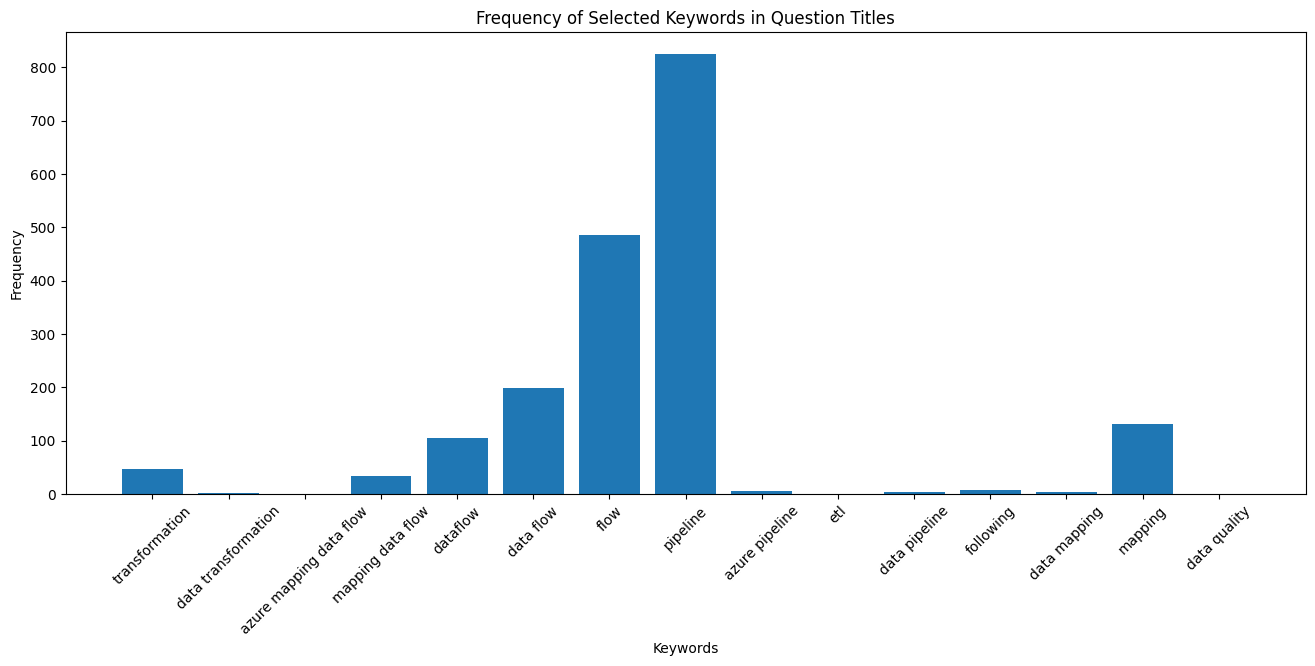

In [99]:
import matplotlib.pyplot as plt

# search question titles for relevant nouns identified in previous data sets and in this data set.
keywords = ['transformation', 'data transformation', 'azure mapping data flow',
            'mapping data flow', 'dataflow', 'data flow', 'flow', 'pipeline', 'azure pipeline',
            'etl', 'data pipeline', 'following', 'data mapping',
            'mapping', 'data quality']


# Create a dictionary to store the counts of each keyword in the title
title_keyword_counts = {keyword: df['QuestionTitle'].str.count(keyword).sum() for keyword in keywords}

plt.figure(figsize=(16, 6))

# Create a bar plot for the title counts
plt.bar(title_keyword_counts.keys(), title_keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Question Titles')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

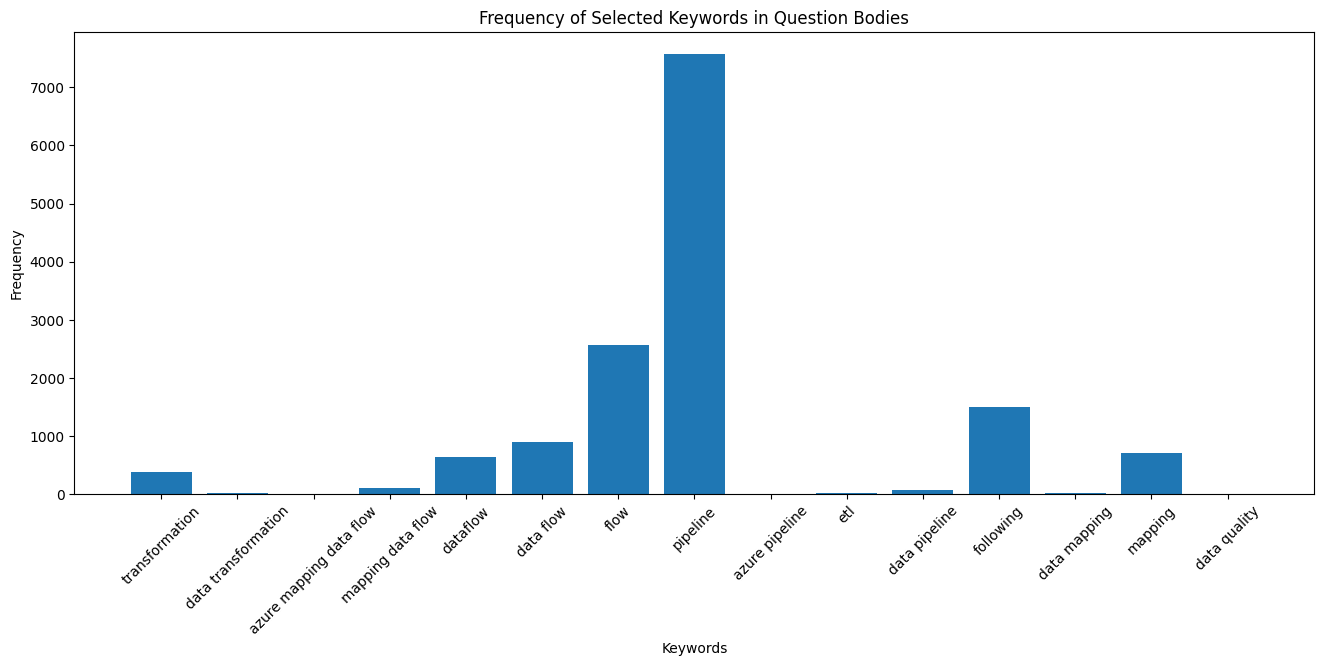

In [102]:
import matplotlib.pyplot as plt

# search question bodies for relevant nouns identified in previous data sets and in this data set.
keywords = ['transformation', 'data transformation', 'azure mapping data flow',
            'mapping data flow', 'dataflow', 'data flow', 'flow', 'pipeline', 'azure pipeline',
            'etl', 'data pipeline', 'following', 'data mapping',
            'mapping', 'data quality']


# Create a dictionary to store the counts of each keyword in the title
title_keyword_counts = {keyword: df['QuestionBody'].str.count(keyword).sum() for keyword in keywords}

plt.figure(figsize=(16, 6))

# Create a bar plot for the title counts
plt.bar(title_keyword_counts.keys(), title_keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Question Bodies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [103]:
# Create a sub set of the dataframe based on relevant nouns

# Define the keywords to search for
keywords = ['dataflow', 'flow', 'data flow']

# Filter the rows containing the keywords
new_df = df[df['QuestionTitle'].str.contains('|'.join(keywords), case=False) | 
            df['QuestionBody'].str.contains('|'.join(keywords), case=False) |
            df['QuestionTags'].str.contains('|'.join(keywords), case=False)]

# Reset the index of the new DataFrame
new_df = new_df.reset_index(drop=True)

# Print the new DataFrame
#print(new_df)

In [104]:
len(new_df)

1730

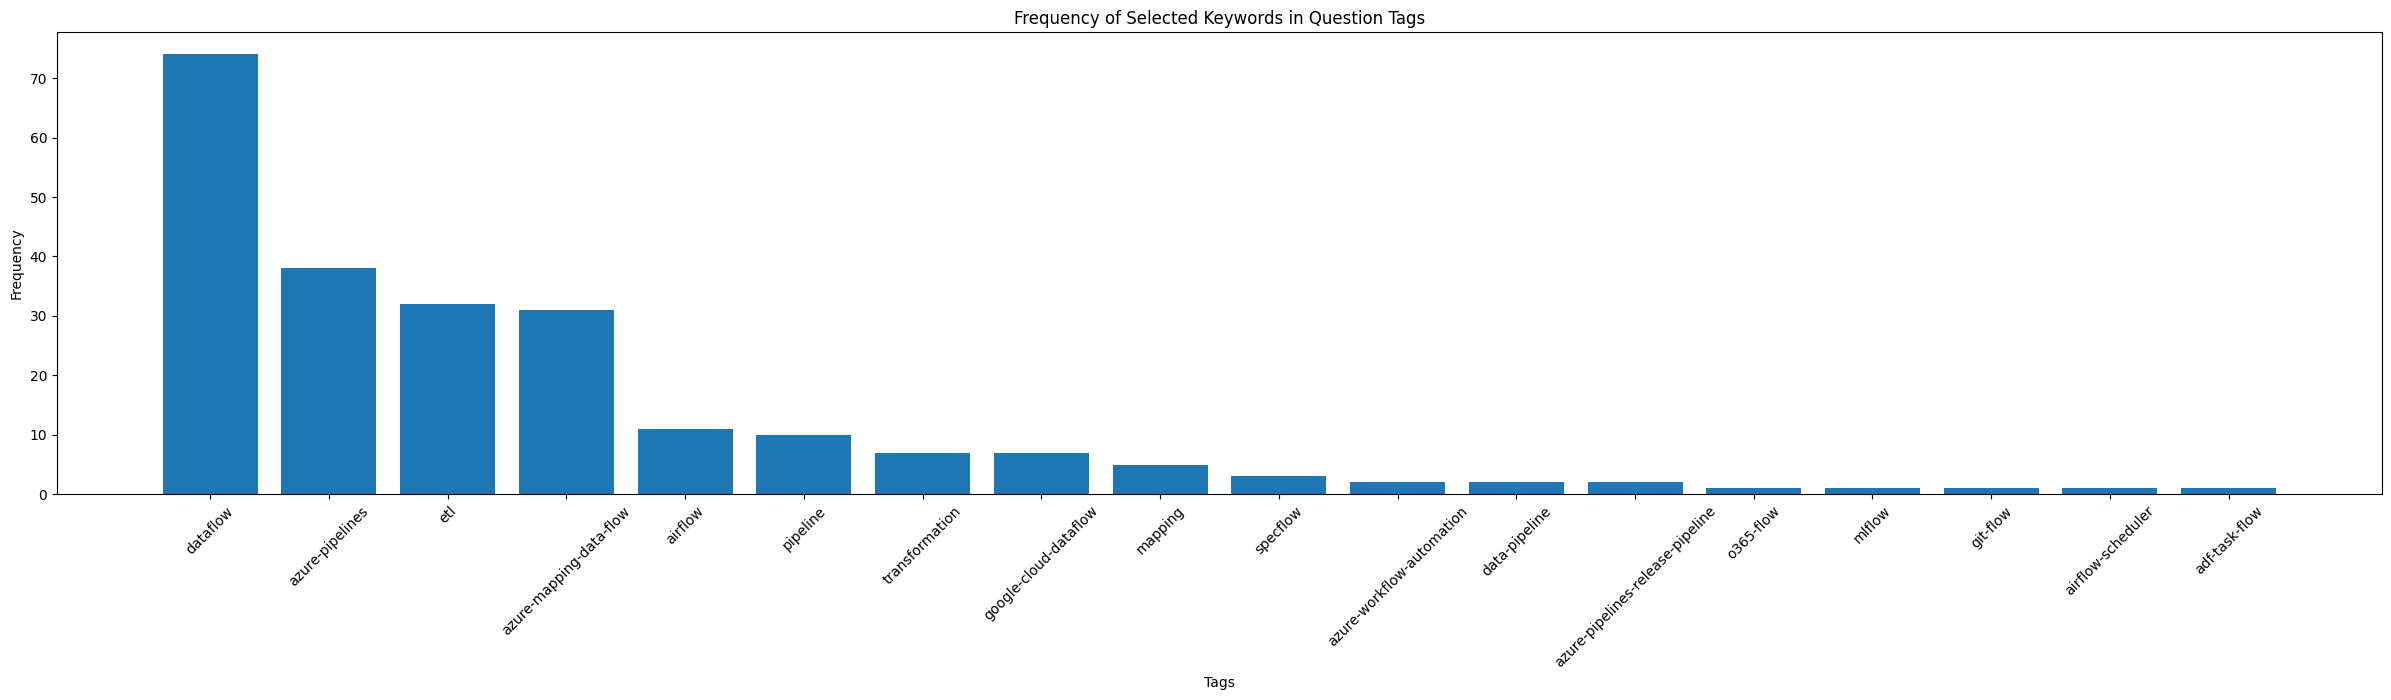

In [108]:
import matplotlib.pyplot as plt

# Look for further relevant keywords within the new subset. 

# Define the keywords to search for
keywords = ['dataflow', 'data flow', 'transformation', 'data transformation', 'azure mapping data flow',
            'mapping data flow', 'flow', 'pipeline', 'azure pipeline',
            'etl', 'data pipeline', 'following', 'data mapping',
            'mapping', 'data quality']

# Extract the tags that contain the keywords
tags_list = new_df['QuestionTags'].str.findall('<(.*?)>').explode().str.lower().str.strip()
filtered_tags = tags_list[tags_list.str.contains('|'.join(keywords))]

# Count the occurrences of each tag
tag_counts = filtered_tags.value_counts()

# Create a bar plot
plt.figure(figsize=(30,6))
plt.bar(tag_counts.index, tag_counts.values)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Question Tags')
plt.xticks(rotation=45)
plt.show()

_Results_:

Relevant Keywords in tags: (dataflow,) data mapping, data pipeline, transformation, mapping, azure mapping data flow, pipeline, etl, azure pipelines

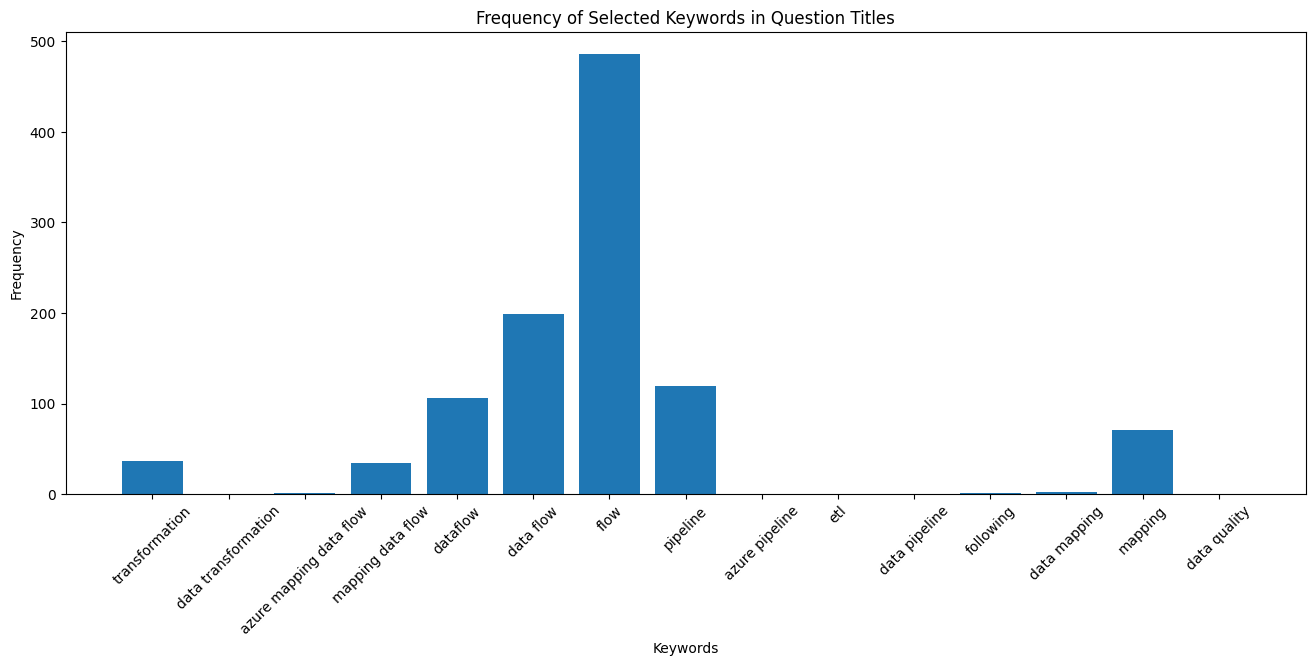

In [110]:
import matplotlib.pyplot as plt

# Define the keywords to search for
keywords = ['transformation', 'data transformation', 'azure mapping data flow',
            'mapping data flow', 'dataflow', 'data flow', 'flow', 'pipeline', 'azure pipeline',
            'etl', 'data pipeline', 'following', 'data mapping',
            'mapping', 'data quality']


# Create a dictionary to store the counts of each keyword in the title
title_keyword_counts = {keyword: new_df['QuestionTitle'].str.count(keyword).sum() for keyword in keywords}

plt.figure(figsize=(16, 6))

# Create a bar plot for the title counts
plt.bar(title_keyword_counts.keys(), title_keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Question Titles')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()



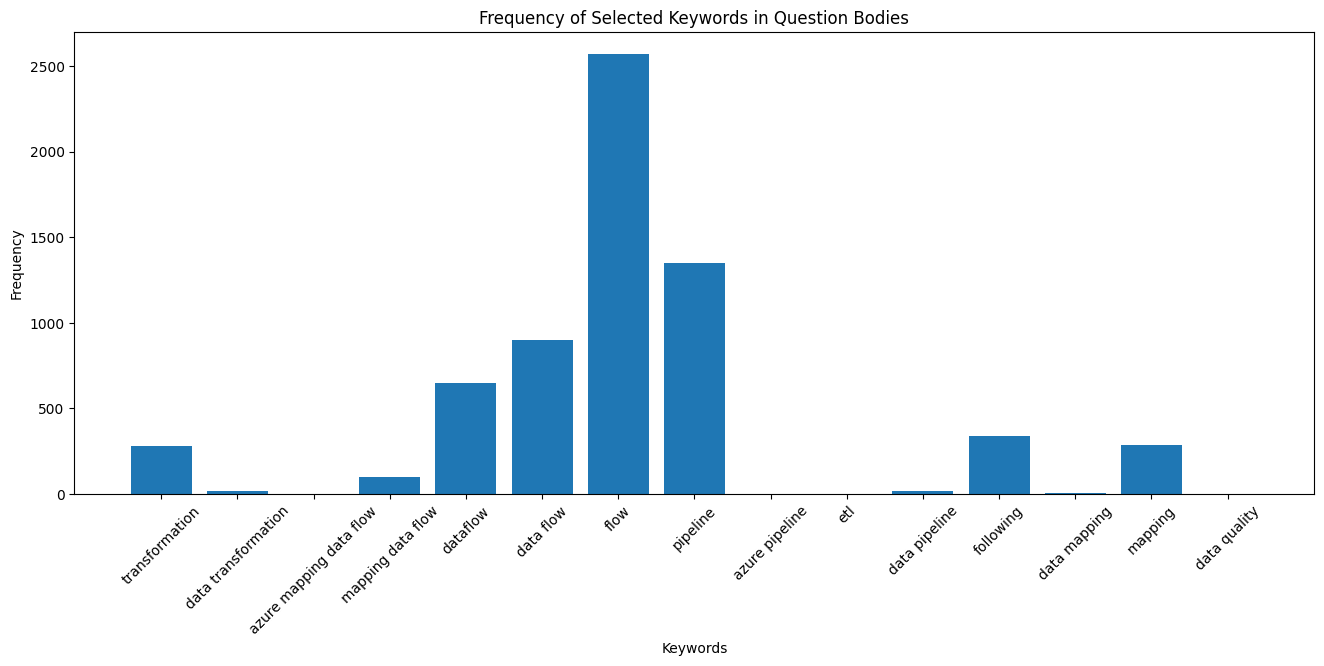

In [111]:
# Create a dictionary to store the counts of each keyword in the question body
body_keyword_counts = {keyword: new_df['QuestionBody'].str.count(keyword).sum() for keyword in keywords}
plt.figure(figsize=(16, 6))
# Create a bar plot for the question body counts
plt.bar(body_keyword_counts.keys(), body_keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Question Bodies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

mapping, data mapping, azure mapping data flow, mapping data flow, following

In [112]:
# Define the keywords for new df:
keywords = ['mapping', 'data mapping', 'azure mapping data flow', 'mapping data flow', 'following']
title_keywords = ['transformation', 'dataflow', 'data flow']

# Filter the rows containing the keywords
new_df_2 = new_df[(new_df['QuestionTitle'].str.contains('|'.join(title_keywords), case=False) | 
                   new_df['QuestionBody'].str.contains('|'.join(title_keywords), case=False)) &
                  ((new_df['QuestionTitle'].str.contains('|'.join(keywords), case=False)) |
                   (new_df['QuestionBody'].str.contains('|'.join(keywords), case=False)) |
                   (new_df['QuestionTags'].str.contains('|'.join(keywords), case=False)))]

In [113]:
len(new_df_2)

463

In [114]:
final_df = new_df_2.copy()

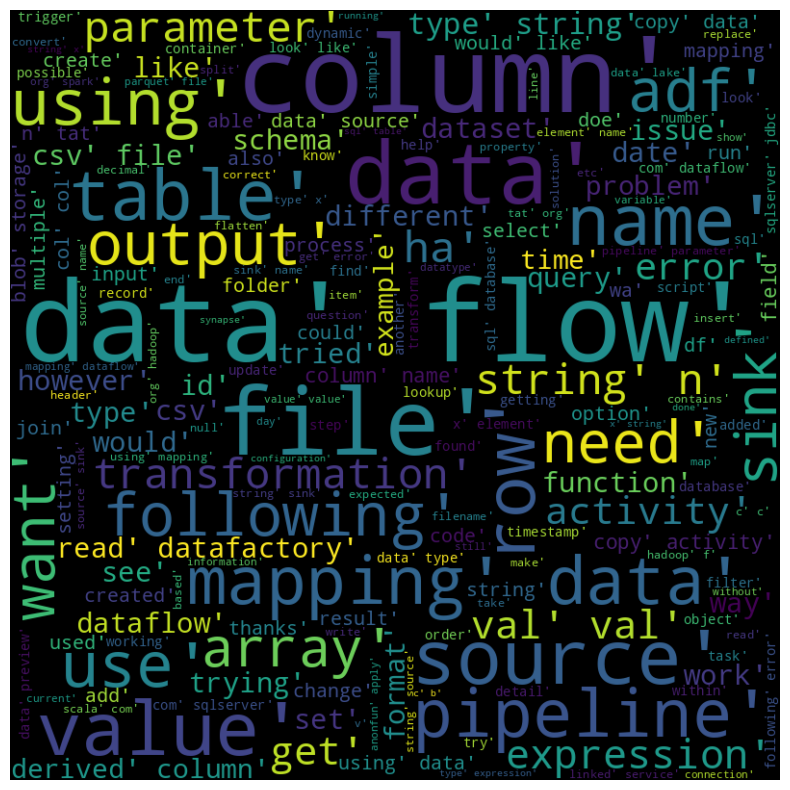

In [118]:
import spacy
import re
from wordcloud import WordCloud, STOPWORDS

# Define stop_words and stop_phrases separately

stop_words = {'azure','microsoft', 'factory', 'one', 'u u', 'two', 'first', 'second', 'azure', 'max', 'mm', 'abc', 'three', 'third', 'mm dd', 'apache', 'today', 'org apache', 'month', 'qnaid qna', 'azure data', 'prem', 'year', 'donesafe', 'json', 'daily', 'microsoft datafactory factory', 'org apache spark', 'py pm', 'dll pm',
'java', 'connectvia'
}

stop_phrases = {'azure data', 'data factory', 'u u', 'azure data factory', 'azure pipeline', 'azure synapse', 
                  'azure sql database', 'azure data lake', 'azure blob storage', 'azure databricks', 'azure devops'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Load the English language model
nlp = spacy.load('en_core_web_lg')

# Combine all the preprocessed texts into a single string
preprocessed_texts = ' '.join(final_df['LemmatizedQuestionBody'].astype(str))

# Remove stop words and stop phrases from the preprocessed_texts
for stopword in all_stop_words:
    preprocessed_texts = re.sub(r'\b' + re.escape(stopword) + r'\b', '', preprocessed_texts, flags=re.IGNORECASE)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800)

# Generate the word cloud with a larger size (e.g., 800x800) and the preprocessed_texts without stopwords
cloud = wordcloud.generate(preprocessed_texts.lower())

# Display the word cloud
plt.figure(figsize=(10, 10))  # Increase the figure size for better visibility
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [119]:
from collections import defaultdict

# Define stop words and stop phrases
stop_words = {'azure','microsoft', 'factory', 'one', 'u u', 'two', 'first', 'second', 'azure', 'max', 'mm', 'abc', 'three', 'third', 'mm dd', 'apache', 'today', 'org apache', 'month', 'qnaid qna', 'azure data', 'prem', 'year', 'donesafe', 'json', 'daily', 'microsoft datafactory factory', 'org apache spark', 'py pm', 'dll pm',
'java', 'connectvia'
}
stop_phrases = {'azure data', 'data factory', 'u u'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Analyze the text and extract entities, nouns, and verbs
entities_counter = defaultdict(int)
nouns_counter = defaultdict(int)
verbs_counter = defaultdict(int)

for _, row in final_df.iterrows():
    question_body = row['LemmatizedQuestionBody']

    question_body = ' '.join(question_body)

    # Remove stop words and stop phrases from the question_body
    for stopword in all_stop_words:
        question_body = re.sub(r'\b' + re.escape(stopword) + r'\b', '', question_body, flags=re.IGNORECASE)
    
    doc = nlp(question_body)
        
    for ent in doc.ents:
        if ent.text.lower() not in stop_words:
            entities_counter[ent.text.lower()] += 1
        
    for token in doc:
        if token.pos_ == 'NOUN' and token.is_alpha and token.text.lower() not in stop_words:
            nouns_counter[token.text.lower()] += 1
        elif token.pos_ == 'VERB' and token.is_alpha and token.text.lower() not in stop_words:
            verbs_counter[token.text.lower()] += 1

# Display the top 10 most common entities, nouns, and verbs
def display_top_n(counter, n, title):
    print(title)
    for item, count in sorted(counter.items(), key=lambda x: x[1], reverse=True)[:n]:
        print(f"{item}: {count}")
    print()

display_top_n(entities_counter, 10, "Top 10 Entities")
display_top_n(nouns_counter, 10, "Top 10 Nouns")
display_top_n(verbs_counter, 10, "Top 10 Verbs")

Top 10 Entities
dfs: 15
yyyy: 13
val val val val: 12
rdd: 12
locale nl nl: 7
d_type: 7
fg etk: 6
tz logid type: 6
sessionid proto: 6
sentbyte rcvdbyte: 6

Top 10 Nouns
data: 1210
column: 834
file: 660
flow: 586
source: 514
type: 507
string: 473
name: 472
value: 448
table: 378

Top 10 Verbs
using: 391
following: 238
get: 181
tried: 169
read: 169
want: 159
trying: 137
use: 132
set: 127
see: 104



In [120]:
# Check for total number of missing values
print(final_df.isnull().sum().sum())

0


In [127]:
import random
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Set the random seed for numpy and python to ensure the same results each time the allocation re-runs
np.random.seed(42)
random.seed(42)

# Prepare the input data by using the lemmatized tokens from the 'LemmatizedQuestionBody' column:
documents = final_df['LemmatizedQuestionBody'].tolist()

# Create a dictionary and a bag of words corpus from the documents:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Set the seed for the random number generator used by the LDA model to a fixed value. 
# Ensures that the same sequence of random numbers is generated every time the model is trained 
# with the same input data and configuration.
random_state_seed = 42 
gensim.models.ldamodel.LdaModel.seed = random_state_seed

# Train the LDA model. You can choose the number of topics by setting the num_topics parameter:
num_topics = 5  # Change this value to the desired number of topics
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15) # Set the number of passes

# Display the top words for each topic
words_per_topic = 10  # Specify the number of top words per topic
for topic in range(num_topics):
    print(f"Topic {topic + 1}:")
    top_words = lda_model.show_topic(topic, topn=words_per_topic)
    for word, weight in top_words:
        print(f"  {word}: {weight:.4f}")
    print()

Topic 1:
  data: 0.0310
  val: 0.0240
  x: 0.0156
  header: 0.0138
  string: 0.0124
  source: 0.0114
  name: 0.0111
  col: 0.0108
  column: 0.0105
  azure: 0.0096

Topic 2:
  data: 0.0422
  flow: 0.0151
  source: 0.0120
  using: 0.0102
  b: 0.0101
  azure: 0.0097
  value: 0.0094
  file: 0.0093
  c: 0.0089
  sql: 0.0084

Topic 3:
  data: 0.0347
  file: 0.0232
  column: 0.0193
  flow: 0.0160
  microsoft: 0.0156
  factory: 0.0150
  read: 0.0133
  datafactory: 0.0123
  mapping: 0.0097
  table: 0.0079

Topic 4:
  data: 0.0261
  column: 0.0256
  file: 0.0127
  n: 0.0122
  azure: 0.0117
  flow: 0.0102
  source: 0.0097
  table: 0.0096
  scala: 0.0093
  name: 0.0088

Topic 5:
  string: 0.0335
  type: 0.0297
  n: 0.0262
  name: 0.0210
  data: 0.0208
  value: 0.0194
  column: 0.0150
  flow: 0.0140
  parameter: 0.0138
  source: 0.0125



In [135]:
# Check for total number of missing values
print(final_df.isnull().sum().sum())

0


In [136]:
# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

final_df['LDATopic'] = final_df['LemmatizedQuestionBody'].apply(assign_topic)

# Get the document-topic matrix and pad with zeros if necessary
doc_topic_matrix = [np.pad([topic_prob for _, topic_prob in lda_model.get_document_topics(bow)], (0, lda_model.num_topics - len(lda_model.get_document_topics(bow))), mode='constant') for bow in corpus]

# Create a new column in the dataset to store the topic names
final_df['LDATopicName'] = ''

# Define a function that returns the topic name based on the index
def get_topic_name(topic_index):
    topic_names = {
        0: 'Topic1',
        1: 'Topic2',
        2: 'Topic3',
        3: 'Topic4',
        4: 'Topic5'
    }
    return topic_names.get(topic_index, '')

# Iterate through the final_df index and assign the topic names
for i, index in enumerate(final_df.index):
    topic_index = np.argmax(doc_topic_matrix[i])
    final_df.at[index, 'LDATopicName'] = get_topic_name(topic_index)

# Check for total number of missing values
print(final_df.isnull().sum().sum())

0


In [137]:
def assign_topic(document):
    if isinstance(document, float):
        return None
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

C:\Users\TanjaWolf_7ms6v6m\AppData\Local\Temp\ipykernel_16380\2437693641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_filtered_final_df2['Tags'] = final_df_filtered_final_df2['Tags'].apply(lambda x: ', '.join(x) if isinstance(x, tuple) else x)


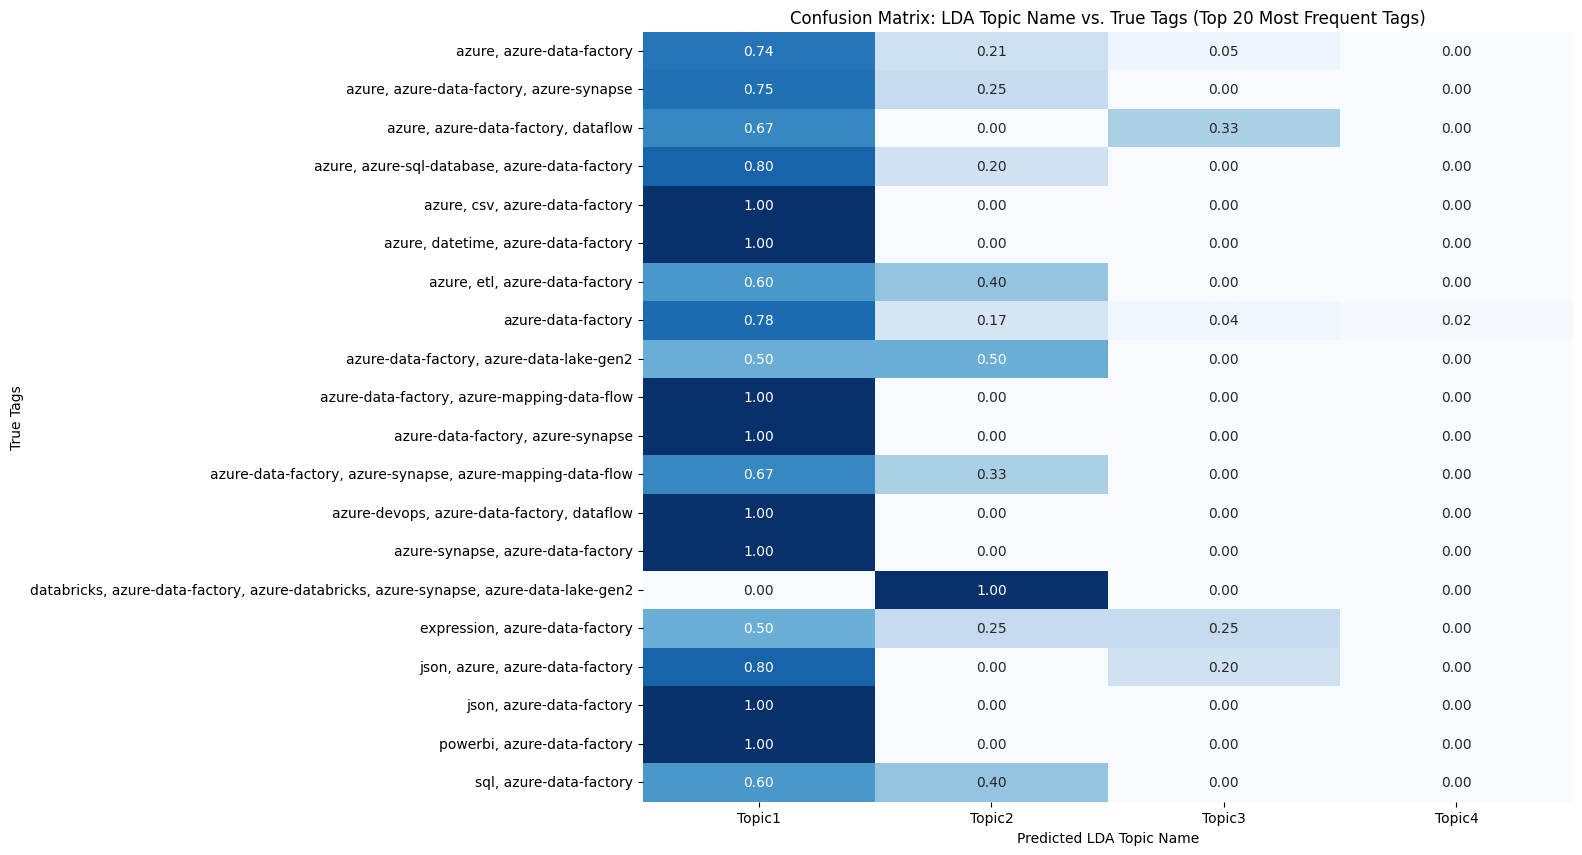

In [138]:
final_df_top_n_tags = 20

# Create a copy of the dataframe and convert lists in 'Tags' column to tuples
final_df_copy = final_df.copy()
final_df_copy['Tags'] = final_df_copy['Tags'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Get the top N most frequent tags
final_df_top_tags = final_df_copy['Tags'].value_counts().nlargest(final_df_top_n_tags).index.tolist()

# Filter the dataset
final_df_filtered_final_df2 = final_df_copy[final_df_copy['Tags'].isin(final_df_top_tags)]

final_df_filtered_final_df2['Tags'] = final_df_filtered_final_df2['Tags'].apply(lambda x: ', '.join(x) if isinstance(x, tuple) else x)
confusion_matrix = pd.crosstab(final_df_filtered_final_df2['Tags'], final_df_filtered_final_df2['LDATopicName'])

# Create a confusion matrix
confusion_matrix = pd.crosstab(final_df_filtered_final_df2['Tags'], final_df_filtered_final_df2['LDATopicName'])

# Normalize the confusion matrix by row to show proportions
final_df_normalized_confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)

plt.figure(figsize=(12, 10))
sns.heatmap(final_df_normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)

plt.xlabel('Predicted LDA Topic Name')
plt.ylabel('True Tags')
plt.title('Confusion Matrix: LDA Topic Name vs. True Tags (Top {} Most Frequent Tags)'.format(final_df_top_n_tags))
plt.show()

_Result:_ The confusion matrix shows four topics insted of five. This can most likely be explained by imbalanced data: Some topics might be underrepresented in the data. There are possibly very few documents related to topic five which is why they do not appear in the confusion matrix. In total there seem to be two relevamt topics in this subset of data. 

In [139]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate the sentiment scores
def get_sentiment_score(text):
    return sia.polarity_scores(text)

# Apply the function to the 'AnswerBody' column and store the sentiment scores in a new column
final_df['VaderSentimentScores'] = final_df['QuestionBody'].apply(get_sentiment_score)

# Calculate the average sentiment score for each topic
avg_sentiment_by_topic = final_df.groupby('LDATopicName')['VaderSentimentScores'].apply(lambda scores: pd.DataFrame(scores.tolist()).mean())

print(avg_sentiment_by_topic)


LDATopicName          
Topic1        neg         0.026560
              neu         0.911378
              pos         0.062033
              compound    0.314505
Topic2        neg         0.030603
              neu         0.905000
              pos         0.064329
              compound    0.275468
Topic3        neg         0.049556
              neu         0.883611
              pos         0.066667
              compound    0.386394
Topic4        neg         0.000000
              neu         0.864000
              pos         0.136000
              compound    0.533250
Name: VaderSentimentScores, dtype: float64


The Vader sentiment analyzer laso find only four topics.

In [133]:
topic_distribution = final_df['LDATopicName'].value_counts()
print(topic_distribution)

LDATopicName
Topic1    368
Topic2     73
Topic3     18
Topic4      4
Name: count, dtype: int64


In [140]:
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

def custom_topic_names(topic_number):
    topic_names = {
        0: 'Topic1',
        1: 'Topic2',
        2: 'Topic3',
        3: 'Topic4',
        4: 'Topic5'
    }
    return topic_names.get(topic_number, '')

lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)

for i in range(num_topics):
    lda_viz.topic_info.loc[lda_viz.topic_info.Category == f'Topic{i+1}', 'Category'] = custom_topic_names(i)
    lda_viz.topic_coordinates.loc[i, 'topics'] = custom_topic_names(i)

pyLDAvis.display(lda_viz)

By examining the topic distribution and visualizing the LDA model, you may find insights on how to improve the model and achieve a better representation of all 10 topics.